## Ambiente Inicial

In [1]:
# librerias
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


In [2]:
script = os.getcwd()
file = os.path.join(script, "data", "BD_IncendiosSNIF_2015-2023.csv")
df = pd.read_csv(file, encoding="latin-1")

C:\Users\Franc\AppData\Local\Temp\ipykernel_4152\4104928706.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file, encoding="latin-1")


In [3]:
df.sample(3)

,Año,Latitud,Longitud,Estado,Municipio,Región,Predio,Fecha Inicio,Fecha Termino,Duración días,...,Renuevo,Arbustivo,Herbáceo,Hojarasca,Total hectáreas,Tamaño,Detección,Llegada,Duración,Causa
36843,2020,19.886339,-103.090219,Jalisco,Mazamitla,Occidente,El Terrero,11/04/2020,11/04/2020,1 Día,...,0,0.0,0.0,0.39,0.39,0 a 5 Hectáreas,0.006944444,0.027777778,0.291666667,Actividades Agrícolas
12091,2017,20.082444,-98.717417,Hidalgo,Mineral de la Reforma,Centro,Las Palomas,27/01/2017,27/01/2017,1 Día,...,0.0,2.2,4.0,0.00,6.20,6 a 10 Hectáreas,0.003472222,0.013888889,0.048611111,Fumadores
49743,2022,19.151361,-98.998764,Ciudad de México,Milpa Alta,Centro,B. C. Santa Ana Tlacotenco,21/03/2022,21/03/2022,1 Día,...,0,0.0,0.0,0.00,0.38,0 a 5 Hectáreas,00:05,00:17,01:12,Actividades ilícitas


## Exploración de datos y limpieza

Comenzaremos por eliminar aquellos espacios en blanco y cambiarlos por "0" para tratarlos después.

In [4]:
df.replace(" ", 0, inplace=True)
df["Renuevo"] = df["Renuevo"].astype(float) 

Ahora corrobaremos que nuestros datos hayan sido leídos correctamente y tengamos los tipos de datos correctos

In [5]:
# Observamos las descripciones estadísticas de nuestras variables númericas
df.describe()

,Año,Latitud,Longitud,Arbolado Adulto,Renuevo,Arbustivo,Herbáceo,Hojarasca,Total hectáreas
count,62441.000000,62441.000000,62441.000000,54758.000000,61506.000000,61918.000000,62002.00000,62141.000000,62441.00000
mean,2019.131324,20.597185,-100.816937,2.204616,1.738875,19.018733,30.34795,23.741466,80.52891
std,2.494713,3.206582,4.395817,40.889945,19.549905,187.361226,267.26755,167.638854,515.37220
min,2015.000000,14.696064,-118.286697,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000
25%,2017.000000,19.119222,-103.558372,0.000000,0.000000,0.000000,0.00000,0.000000,1.50000
50%,2019.000000,19.552250,-99.927250,0.000000,0.000000,0.500000,1.00000,0.000000,5.00000
75%,2021.000000,20.892500,-98.712803,0.000000,0.000000,4.000000,6.00000,3.590000,23.65000
max,2023.000000,32.599875,-86.798778,4893.000000,1271.710000,17382.420000,17220.15000,8717.330000,23809.00000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62441 entries, 0 to 62440
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Año               62441 non-null  int64  
 1   Latitud           62441 non-null  float64
 2   Longitud          62441 non-null  float64
 3   Estado            62441 non-null  object 
 4   Municipio         62441 non-null  object 
 5   Región            62441 non-null  object 
 6   Predio            62441 non-null  object 
 7   Fecha Inicio      62438 non-null  object 
 8   Fecha Termino     62441 non-null  object 
 9   Duración días     62440 non-null  object 
 10  Tipo de incendio  62441 non-null  object 
 11  Tipo Vegetación   62441 non-null  object 
 12  Régimen de fuego  62441 non-null  object 
 13  Tipo impacto      62441 non-null  object 
 14  Arbolado Adulto   54758 non-null  float64
 15  Renuevo           61506 non-null  float64
 16  Arbustivo         61918 non-null  float6

En esta sección trataremos los valores categoricos para normalizar nuestras respuestas, ya que hay mucha variabilidad entre respuestas.

In [7]:
# Normalización de Columnas con valores categoricos variables
estados = {
    'Ciudad De México':'Ciudad de México',
    'México':'Ciudad de México'
}

df["Estado"] = df["Estado"].replace(estados) 

In [8]:
municipios = { 
    "Alamos":"Álamos",
    "Angel Albino Corzo":"Ángel Albino Corzo"
}
df['Municipio'] = df['Municipio'].replace(municipios)

In [9]:
df["Duración días"] = df["Duración días"].replace("#¡REF!", "0")
df["Duración días"] = df["Duración días"].replace("0", "Desconocido")

In [10]:
incendios = {
    'superficial':'Superficial',
    'SUPERFICIAL':'Superficial',
    'mixto':'Mixto',
    '0':"Desconocido"
}
df["Tipo de incendio"] = df["Tipo de incendio"].replace(incendios)

In [11]:
vegetacion = {
    '0':"Desconocida",
    "Bosque Cultivado - BC":"Bosque Cultivado",
    "Bosque de Ayarín - BS":"Bosque de Ayarín",
    "Bosque de Cedro - BB":"Bosque de Cedro",
    "Bosque de Encino":"Bosque de Encino",
    "Bosque de Encino - BQ":"Bosque de Encino",
    "Bosque de \nEncino ":"Bosque de Encino",
    "Bosque de Encino-Pino - BQP":"Bosque de Encino-Pino",
    "Bosque de Galería - BG":"Bosque de Galería",
    "Bosque de Oyamel - BA":"Bosque de Oyamel",
    "Bosque de pino":"Bosque de Pino",
    "Bosque de \npino":"Bosque de Pino",
    "Bosque de Pino - BP":"Bosque de Pino",
    "bosque de pino - BP":"Bosque de Pino",
    "Bosque de pino - BP":"Bosque de Pino",
    "bosque de pino":"Bosque de Pino",
    "Bosque de \nPino":"Bosque de Pino",
    "Bosque de Pino-Encino - BPQ":"Bosque de Pino-Encino",
    "bosque de pino-encino":"Bosque de Pino-Encino",
    "Bosque de Táscate - BJ":"Bosque de Táscate",
    "Bosque Inducido - BI":"Bosque Inducido",
    "Bosque Mesófilo - BM":"Bosque Mesófilo",
    "Bosque Mesofilo - BM":"Bosque Mesófilo",
    "Chaparral - ML":"Chaparral",
    "Manglar - VM":"Manglar",
    "Matorral Crasicaule - MC":"Matorral Crasicaule",
    "Matorral de Coníferas - MJ":"Matorral de Coníferas",
    "Matorral Desertico Micrófilo":"Matorral Desértico Micrófilo",
    "Matorral Desértico Micrófilo - MDM":"Matorral Desértico Micrófilo",
    "Matorral Desertico Rosetófilo":"Matorral Desértico Rosetófilo",
    "Matorral Desértico Rosetófilo - MDR":"Matorral Desértico Rosetófilo",
    "Matorral Espinoso Tamaulipeco - MET":"Matorral Espinoso Tamaulipeco",
    "Matorral Rosetófilo Costero - MRC":"Matorral Rosetófilo Costero",
    "Matorral Sarcocaule - MSC":"Matorral Sarcocaule",
    "Matorral Sarco-Crasicaule":"Matorral Sarcocrasicaule",
    "Matorral Sarcocrasicaule - MSCC":"Matorral Sarcocrasicaule",
    "Matorral Submontano - MSM":"Matorral Submontano",
    "Matorral Subtropical - MST":"Matorral Subtropical",
    "Mezquital (Xerófilo) - MKX":"Mezquital Xerófilo",
    "Palmar Inducido - VPI":"Palmar Inducido",
    "Palmar Natural - VPN":"Palmar Natural",
    "Pastizal Gypsófilo":"Pastizal Gipsófilo",
    "Pastizal Halófilo - PH":"Pastizal Halófilo",
    "Pastizal Inducido - PU":"Pastizal Inducido",
    "Pastizal Natural - PN":"Pastizal Natural",
    "Petén - PT":"Petén",
    "Popal - VA":"Popal",
    "Pradera de Alta Montaña - VW":"Pradera de Alta Montaña",
    "Sabana - VS":"Sabana",
    "Sabanoide - VSI":"Sabanoide",
    "Selva alta perennifolia - SAP":"Selva Alta Perennifolia",
    "Selva alta perennifolia":"Selva Alta Perennifolia",
    "Selva alta subperennifolia - SAQ":"Selva Alta Subperennifolia",
    "Selva baja caducifolia - SBC":"Selva Baja Caducifolia",
    "Selva baja caducifolia":"Selva Baja Caducifolia",
    "Selva baja espinosa - SBK":"Selva Baja Espinosa",
    "Selva baja perennifolia - SBP":"Selva Baja Perennifolia",
    "Selva baja perennifolia":"Selva Baja Perennifolia",
    "Selva baja subcaducifolia - SBS":"Selva Baja Subcaducifolia",
    "Selva baja subcaducifolia":"Selva Baja Subcaducifolia",
    "Selva baja subperennifolia - SBQ":"Selva Baja Subperennifolia",
    "Selva baja subperennifolia":"Selva Baja Subperennifolia",
    "Selva mediana caducifolia - SMC":"Selva Mediana Caducifolia",
    "Selva mediana caducifolia":"Selva Mediana Caducifolia",
    "Selva mediana perennifolia - SMP":"Selva Mediana Perennifolia",
    "Selva mediana perennifolia":"Selva Mediana Perennifolia",
    "Selva mediana subcaducifolia - SMS":"Selva Mediana Subcaducifolia",
    "selva mediana subcaducifolia":"Selva Mediana Subcaducifolia",
    "Selva mediana subperennifolia - SMQ":"Selva Mediana Subperennifolia",
    "Selva mediana subperennifolia":"Selva Mediana Subperennifolia",
    "Tular - VT":"Tular",
    "Vegetación de Dunas Costeras - VU":"Vegetación de Dunas Costeras",
    "Vegetación de Galería - VG":"Vegetación de Galería",
    "Vegetación Halofila Hidrófila":"Vegetación Halófila Hidrófila",
    "Vegetación Halófila (Hidrófila) - VHH":"Vegetación Halófila Hidrófila",
    "Vegetacion Hidrofila":"Vegetación Halófila Hidrófila",
    "Vegetación Halófila (Xerófila) - VH":"Vegetación Halófila Xerófila",
    "Vegetación Halofila Xerofila":"Vegetación Halófila Xerófila",
}
df['Tipo Vegetación'] = df['Tipo Vegetación'].replace(vegetacion)

#'bosque de pino - BP', 'Bosque de pino - BP','bosque de pino'

In [12]:
impactos = {'Impacto Mínimo':"Impacto Minimo",
'impacto mínimo':"Impacto Minimo",
'impacto Mínimo':"Impacto Minimo",
'Impacto mínimo':"Impacto Minimo",
'Impacto MÍnImo':"Impacto Minimo",
'impacto moderado':'Impacto Moderado',
'Impacto moderado':'Impacto Moderado',
'impacto severo':'Impacto Severo',
'Impacto severo':'Impacto Severo',
'0':"Impacto Nulo",
}
df["Tipo impacto"] = df["Tipo impacto"].replace(impactos)

In [13]:
df["Tamaño"] = df["Tamaño"].replace({'0':"Desconocido"})

In [14]:
causas = {
    'fumadores':"Fumadores",
    'actividades pecuarias':"Actividades Pecuarias",
    'Actividades pecuarias':"Actividades Pecuarias",
    'cazadores':"Cazadores",
    'actividades ilícitas':"Actividades Ilícitas",
    'Quema de basureros':"Quema de Basureros",
    'Otras actividades productivas':"Otras Actividades Productivas",
    'Residuos de aprovechamiento forestal':"Residuos de Aprovechamiento Forestal",
    'fogatas':"Fogatas",
    'Actividades agrícolas':"Actividades Agrícolas",
    'DESCONOCIDAS':"Desconocidas",
    'Actividades ilícitas': "Actividades Ilícitas"
}
df["Causa"] = df["Causa"].replace(causas) 

Una vez que ya estén normalizadas las respuestas procederemos a limpiar los datos nulos o con valores "0" que asignamos anteriormente.

In [15]:
# Mostramos si existe aunque sea 1 dato nulo en cada columna
df.isnull().any()

Año                 False
Latitud             False
Longitud            False
Estado              False
Municipio           False
Región              False
Predio              False
Fecha Inicio         True
Fecha Termino       False
Duración días        True
Tipo de incendio    False
Tipo Vegetación     False
Régimen de fuego    False
Tipo impacto        False
Arbolado Adulto      True
Renuevo              True
Arbustivo            True
Herbáceo             True
Hojarasca            True
Total hectáreas     False
Tamaño              False
Detección           False
Llegada             False
Duración            False
Causa               False
dtype: bool

Como podemos observar en los resultados obtenidos arriba, tenemos algunas columnas que cuentan con datos nulos, las cuales son: *Fecha Inicio, Duración Días, Arbolado Adulto, Renuevo, Arbustivo, Herbáceo, Hojarasca*. <br>

Para ajustar los valores nulos en las columnas de fechas simplemente se observarán los datos en los registros de "Fecha Termino" y "Duración días", para inferir las fechas faltantes.

In [16]:
# Corrección de valores faltantes en Fechas
df.loc[62438, "Fecha Inicio"] = "27/02/2015"
df.loc[62439, "Fecha Inicio"] = "13/03/2015"
df.loc[62440, "Fecha Inicio"] = "16/03/2015"
# Correción duración de días
df.loc[2064, "Duración días"] = '1 Día'
# Correción Detección
df.loc[35812, "Detección"] = '00:05:00'


Ahora, las siguientes columnas tiene algo de similar en cuanto a la razón de sus valores nulos, y es que no existe información para rellenar el espacio correspondiente, por lo cual al ser información faltante simplemente se le asignará un 0.

In [17]:
# Corrección de valores faltantes en Arbolados Adultos
df["Arbolado Adulto"] = df["Arbolado Adulto"].fillna(0)
# Corrección de valores faltantes en Renuevo
df["Renuevo"] = df["Renuevo"].fillna(0)
# Corrección de valores faltantes en Arbustivos
df["Arbustivo"] = df["Arbustivo"].fillna(0)
# Corrección de valores en Herbáceos
df["Herbáceo"] = df["Herbáceo"].fillna(0)
# Correción de valores en Hojarascas
df["Hojarasca"] = df["Hojarasca"].fillna(0)

In [18]:
# Correción de valores con errores de digitación
df["Detección"] = df["Detección"].str.replace(";:", ":")
df["Detección"] = df["Detección"].str.replace("::", ":")
df["Llegada"] = df["Llegada"].str.replace(";", ":")
df["Duración"] = df["Duración"].str.replace(";", ":")
df["Llegada"] = df["Llegada"].str.replace(r':000\b', ":00", regex=True)
df["Llegada"] = df["Llegada"].str.replace("::", ":")
df["Duración"] = df["Duración"].str.replace(" a.m.", "")
df["Duración"] = df["Duración"].str.replace(" a. m.", "")
df["Duración"] = df["Duración"].str.replace("  ", "")
df["Duración"] = df["Duración"].str.replace(" ", "")
#26:28:00 a.m.  a. m.

In [19]:
df[["Fecha Inicio", "Fecha Termino"]] = df[["Fecha Inicio", "Fecha Termino"]].apply(pd.to_datetime, format="%d/%m/%Y")

Ahora comprobaremos que los datos hayan sido tratados correctamente:

In [20]:
df.sample(5)

,Año,Latitud,Longitud,Estado,Municipio,Región,Predio,Fecha Inicio,Fecha Termino,Duración días,...,Renuevo,Arbustivo,Herbáceo,Hojarasca,Total hectáreas,Tamaño,Detección,Llegada,Duración,Causa
49468,2022,25.313083,-100.145750,Nuevo León,Santiago,Noreste,Las Adjuntas,2022-03-14,2022-03-19,4 a 7 Días,...,1.03,5.88,41.62,48.58,163.36,Mayor a 100 Hectáreas,00:05,00:55,02:20,Quema de Basureros
58294,2023,19.849706,-102.041500,Michoacán,Chilchota,Occidente,C.i. De Carapan,2023-04-15,2023-04-15,1 Día,...,0.00,1.60,1.00,2.00,4.60,0 a 5 Hectáreas,00:10:00,02:47:00,67:45:00,Desconocidas
29744,2019,25.361244,-100.339508,Nuevo León,Santiago,Noreste,Ejido San Isidro,2019-04-02,2019-04-05,4 a 7 Días,...,0.00,0.50,0.25,0.25,1.00,0 a 5 Hectáreas,0.006944444,0.013888889,0.375,Naturales
61590,2023,26.641597,-106.410789,Chihuahua,Balleza,Norte,"Ej. La Pinta, La Joya Y Anexos",2023-06-14,2023-06-18,4 a 7 Días,...,7.00,230.00,700.00,220.62,1157.62,Mayor a 100 Hectáreas,00:10:00,00:50:00,29:30:00,Intencional
5271,2016,15.308289,-92.379211,Chiapas,Motozintla,Sureste,Ejido Belisario Domínguez,2016-02-27,2016-02-28,2 a 3 Días,...,0.00,0.00,6.00,0.00,6.00,6 a 10 Hectáreas,0.013888889,0.03125,0.395833333,Fumadores


Explorando un poco el set de datos podemos observar que para las columnas relativas a series de tiempo, en este caso las columnas = *Detección, Llegada y Duración* las 3 cuentan con diferente formatos de medir el tiempo así que para poder continuar con nuestro análisis se realizarán las transformación necesarias para normalizar estás columnas a un sólo formato de Horas:Minutos:Segundos (HH:MM:SS), y para los casos extraordinarios se añadirá la insignia de "eliminar" para aquellos casos en los que fue un poco complicado comprender la naturaleza de la información. Por lo cuál al terminar la transformación, aquellos registros que cuenten con algún valor "eliminar" en sus registros serán eliminados de éste análisis.

In [21]:
def convert_to_hours(time_str):
    """Función para transformar diferentes tipos de registros en un formato de hora
    HH:mm:ss.
    """
    if re.match(r'^\d{3,}:\d{2}:\d{2}$', time_str):  # Sí el del tipo 608:30:00
        return "eliminar"
    elif re.match(r'^\d{2}:\d{2}:\d{2}$', time_str):  # Si es del tipo 00:30:00 
        horas, minutos, segundos = map(int, time_str.split(':'))
        if horas < 24:
            return time_str
        else:
            return "eliminar"
    elif re.match(r'^\d{1}\:\d{2}\:\d{2}$', time_str):# Sí es del tipo 13:25:43
        return time_str.zfill(8)
    elif re.match(r'^\d{2}:\d{2}$', time_str):# Si es del tipo 02:25
        return time_str + ":00"
    elif re.match(r'\d+\.\d+$', time_str): # 3.165
        horas = float(time_str) * 24
        # Calcula las horas enteras
        horas_enteras = int(horas)
        # Calcula los minutos y segundos
        minutos = int((horas - horas_enteras) * 60)
        segundos = int(((horas - horas_enteras) * 60 - minutos) * 60)
        # Formatea la salida como HH:MM:SS
        if horas_enteras <24:
            return "{:02d}:{:02d}:{:02d}".format(horas_enteras, minutos, segundos)
        else:
            return "eliminar"
    elif re.match(r"\d+$", time_str): # Sí es del tipo 1,25,79
        if int(time_str) <24:
            return "00:00:00"
        else:
            return "eliminar"
    elif re.match(r"^\d{3,}\:\d{2}$", time_str):
        return "eliminar"
    else:
        raise ValueError(f"Formato no reconocido: {time_str}")

In [22]:
def duration(time_str):
    """Función para transformar valores en datos del tipo XXX:XX:XX
    para observar la duración del incendio registrada.
    """
    if re.match(r'^\d{3,}:\d{2}:\d{2}$', time_str):  # Sí el del tipo 608:30:00
        return time_str
    elif re.match(r'^\d{2}:\d{2}:\d{2}$', time_str):  # Si es del tipo 00:30:00 
        return time_str
    elif re.match(r'^\d{1}\:\d{2}\:\d{2}$', time_str):# Sí es del tipo 13:25:43
        return time_str.zfill(8)
    elif re.match(r'^\d{2}:\d{2}$', time_str):# Si es del tipo 02:25
        return time_str + ":00"
    elif re.match(r'\d+\.\d+$', time_str): # 3.165
        horas = float(time_str) * 24
        # Calcula las horas enteras
        horas_enteras = int(horas)
        # Calcula los minutos y segundos
        minutos = int((horas - horas_enteras) * 60)
        segundos = int(((horas - horas_enteras) * 60 - minutos) * 60)
        # Formatea la salida como HH:MM:SS
        return "{:02d}:{:02d}:{:02d}".format(horas_enteras, minutos, segundos)
    elif re.match(r"\d+$", time_str): # Sí es del tipo 1,25,79
        hora = int(time_str)*24
        return f"{hora}:00:00"
    elif re.match(r"^\d{3,}\:\d{2}$", time_str):
        return time_str + ":00"
    else:
        raise ValueError(f"Formato no reconocido: {time_str}")


In [23]:
# Aplicamos cada función a cada columna correspondiente
df["Detección"] = df["Detección"].apply(convert_to_hours)
df["Llegada"] = df["Llegada"].apply(convert_to_hours)
df["Duración"] = df["Duración"].apply(duration)

Ahora mismo tenemos nuestras columnas de *Detección, Llegada y Duración* tratadas a los mismos formatos lo que nos hará, mucho más sencillo continuar con nuestro análisis.

In [24]:
df[["Detección", "Llegada", "Duración"]].sample(5)

,Detección,Llegada,Duración
17248,00:04:59,01:25:00,04:59:59
58762,00:15:00,00:45:00,02:15:00
47835,01:09:59,eliminar,35:50:00
33396,00:00:10,00:00:14,00:02:00
60825,00:07:00,01:10:00,05:10:00


Para finalizar observaremos cuentos datos fueron catalogados para ser eliminados por cada variable:

In [25]:
df[df[["Detección", "Llegada", "Duración"]]=="eliminar"].count()

Año                    0
Latitud                0
Longitud               0
Estado                 0
Municipio              0
Región                 0
Predio                 0
Fecha Inicio           0
Fecha Termino          0
Duración días          0
Tipo de incendio       0
Tipo Vegetación        0
Régimen de fuego       0
Tipo impacto           0
Arbolado Adulto        0
Renuevo                0
Arbustivo              0
Herbáceo               0
Hojarasca              0
Total hectáreas        0
Tamaño                 0
Detección            357
Llegada             1045
Duración               0
Causa                  0
dtype: int64

In [26]:
# Obteniendo el set de datos sin los datos categorizados para eliminación.
df = df[df["Detección"] != "eliminar"]
df = df[df["Llegada"] != "eliminar"]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 61155 entries, 0 to 62440
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Año               61155 non-null  int64         
 1   Latitud           61155 non-null  float64       
 2   Longitud          61155 non-null  float64       
 3   Estado            61155 non-null  object        
 4   Municipio         61155 non-null  object        
 5   Región            61155 non-null  object        
 6   Predio            61155 non-null  object        
 7   Fecha Inicio      61155 non-null  datetime64[ns]
 8   Fecha Termino     61155 non-null  datetime64[ns]
 9   Duración días     61155 non-null  object        
 10  Tipo de incendio  61155 non-null  object        
 11  Tipo Vegetación   61155 non-null  object        
 12  Régimen de fuego  61155 non-null  object        
 13  Tipo impacto      61155 non-null  object        
 14  Arbolado Adulto   61155 non

In [28]:
df[df[["Detección", "Llegada", "Duración"]]=="eliminar"].count()

Año                 0
Latitud             0
Longitud            0
Estado              0
Municipio           0
Región              0
Predio              0
Fecha Inicio        0
Fecha Termino       0
Duración días       0
Tipo de incendio    0
Tipo Vegetación     0
Régimen de fuego    0
Tipo impacto        0
Arbolado Adulto     0
Renuevo             0
Arbustivo           0
Herbáceo            0
Hojarasca           0
Total hectáreas     0
Tamaño              0
Detección           0
Llegada             0
Duración            0
Causa               0
dtype: int64

In [29]:
df.shape

(61155, 25)

In [30]:
# Ahora limpiamos el conjunto de datos de aquellos datos Desconocidos
df=df[~df.isin(["Desconocido"]).any(axis=1)]

Una vez que comprobado que efectivamente no tenemos más datos nulos y que nuestras respuestas categoricas están normalizadas, ahora podemos continuar con nuestro análisis exploratorio.

## Visualizaciones

Para poder observar las relaciones entre nuestros datos, primero observaremos las distribuciones de nuestras variables por tipo.

In [31]:
df.iloc[:,9:].head()

,Duración días,Tipo de incendio,Tipo Vegetación,Régimen de fuego,Tipo impacto,Arbolado Adulto,Renuevo,Arbustivo,Herbáceo,Hojarasca,Total hectáreas,Tamaño,Detección,Llegada,Duración,Causa
0,2 a 3 Días,Superficial,Bosque de Encino,Adaptado,Impacto Minimo,0.0,0.0,0.00,0.0,1.5,1.50,0 a 5 Hectáreas,00:09:59,00:35:00,07:00:00,Desconocidas
1,1 Día,Superficial,Pastizal Natural,Adaptado,Impacto Minimo,0.0,0.0,1.50,0.0,0.0,1.50,0 a 5 Hectáreas,00:08:00,00:40:00,02:50:00,Actividades Ilícitas
2,1 Día,Superficial,Desconocida,Otros,Impacto Minimo,0.0,0.0,1.00,0.0,0.0,1.00,0 a 5 Hectáreas,00:04:59,00:15:00,24:20:00,Actividades Ilícitas
3,1 Día,Superficial,Bosque de Pino,Adaptado,Impacto Minimo,0.0,0.0,0.00,0.5,0.0,0.50,0 a 5 Hectáreas,00:06:00,00:24:59,01:41:00,Actividades Pecuarias
4,1 Día,Superficial,Bosque de Pino,Adaptado,Impacto Minimo,0.0,0.0,0.25,0.0,0.0,0.25,0 a 5 Hectáreas,00:20:00,00:35:00,25:59:59,Fumadores


Realizaremos la separación de nuestras variables en diferentes grupos de variables.

In [32]:
categorical_variables = df[["Estado", "Municipio", "Región", "Predio","Duración días","Tipo de incendio", "Tipo Vegetación", "Régimen de fuego", "Tipo impacto", "Tamaño", "Causa"]].copy()
numerical_variables = df[["Latitud", "Longitud", "Arbolado Adulto", "Renuevo", "Arbustivo", "Herbáceo", "Hojarasca", "Total hectáreas"]].copy()
times_variables = df[["Año", "Fecha Inicio", "Fecha Termino", "Detección", "Llegada", "Duración"]].copy()

In [33]:
categorical_variables.sample(3)

,Estado,Municipio,Región,Predio,Duración días,Tipo de incendio,Tipo Vegetación,Régimen de fuego,Tipo impacto,Tamaño,Causa
8764,Chihuahua,Bocoyna,Norte,P.P. Cuesta prieta,1 Día,Mixto,Bosque de Pino-Encino,Adaptado,Impacto Moderado,6 a 10 Hectáreas,Actividades Ilícitas
20828,Michoacán,Ario,Occidente,Pequeña Propiedad de Paso Real,1 Día,Superficial,Bosque de Pino,Adaptado,Impacto Minimo,6 a 10 Hectáreas,Actividades Agrícolas
42149,Ciudad de México,Nicolás Romero,Centro,Ejido Cahuacan / Desconocido,1 Día,Superficial,Bosque de Pino,Adaptado,Impacto Minimo,0 a 5 Hectáreas,Fogatas


In [34]:
numerical_variables.sample(3)

,Latitud,Longitud,Arbolado Adulto,Renuevo,Arbustivo,Herbáceo,Hojarasca,Total hectáreas
31143,19.034111,-99.733194,0.0,0.0,2.00,1.0,0.00,3.00
52388,19.782014,-103.518411,0.0,0.0,0.00,2.0,3.54,5.54
60887,22.161517,-104.101492,0.0,0.0,0.44,40.0,3.00,43.44


In [35]:
times_variables.sample(3)

,Año,Fecha Inicio,Fecha Termino,Detección,Llegada,Duración
28609,2019,2019-03-11,2019-03-11,01:20:00,00:29:59,10:30:00
60992,2023,2023-06-01,2023-06-03,01:10:00,02:40:00,363:40:00
10366,2016,2016-05-19,2016-05-19,00:15:00,01:00:00,18:29:59


## Análisis Univariable

### Variables Categoricas

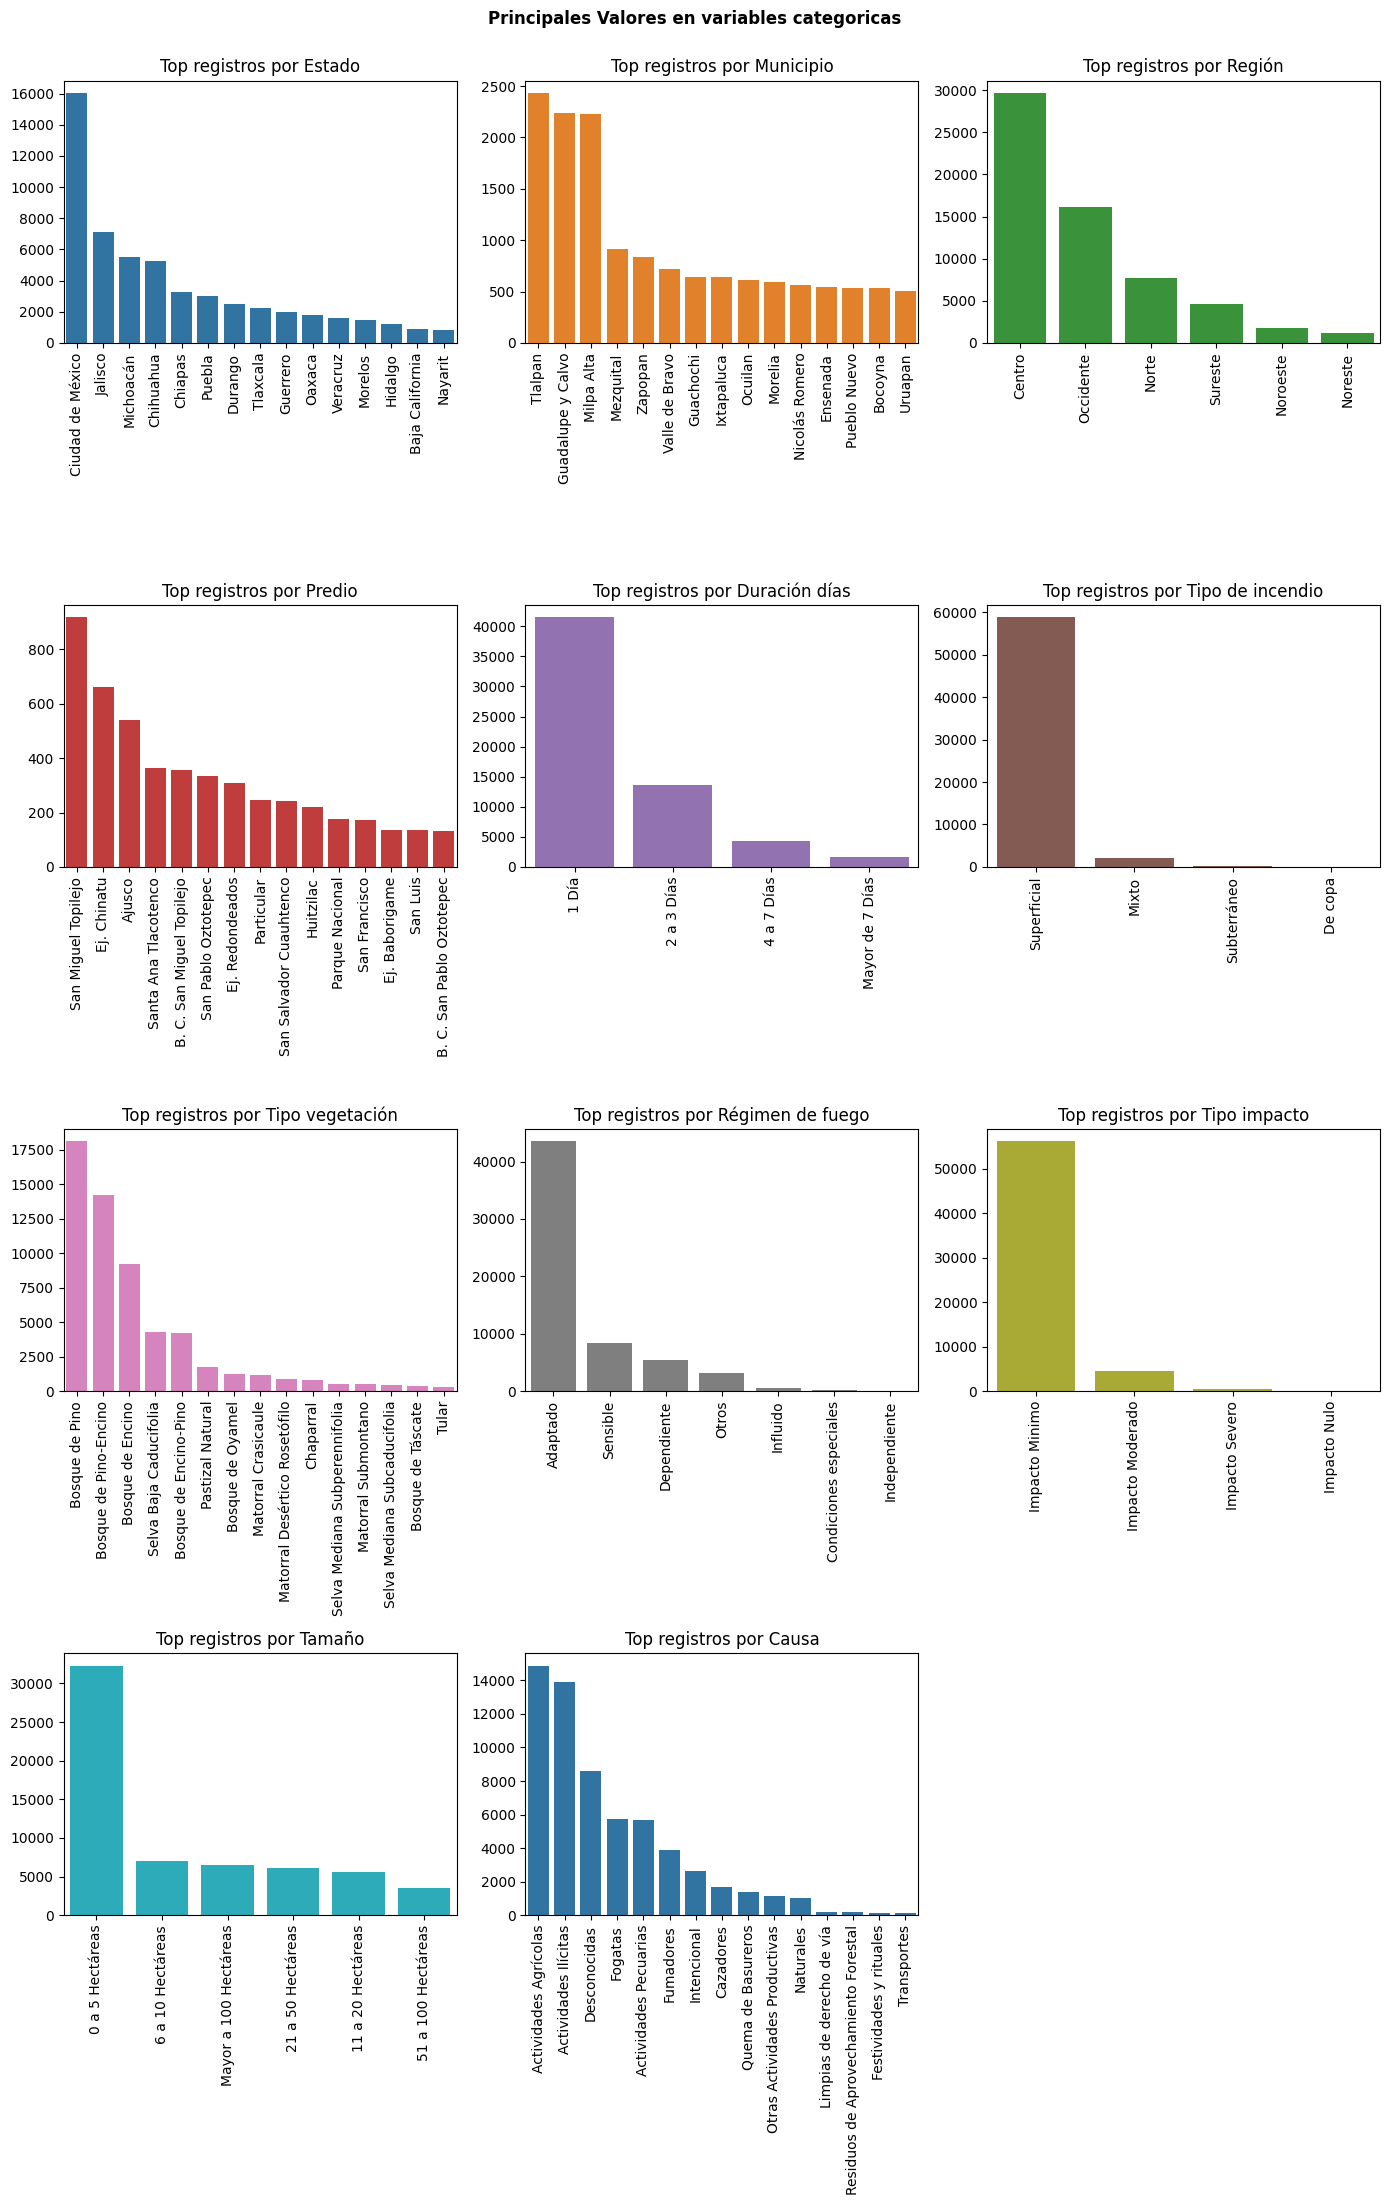

In [36]:
# Mostrando los registros conmayores ocurrencia en variables categoricas
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(14,22))
plt.subplots_adjust(hspace=1)
ax = ax.flat
# Palette
colors = sns.color_palette(palette = 'tab10', n_colors = len(df.columns)+2)
for i, column in enumerate(categorical_variables.columns):
    sns.barplot(df[column].value_counts().head(15), ax=ax[i], color=colors[i])
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f"Top registros por {column.capitalize()}")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")

plt.suptitle("Principales Valores en variables categoricas", y=1, fontweight="bold")
fig.delaxes(ax[11])
plt.tight_layout()
plt.show()

Con las gráficas anteriores es sencillo observar aquellos registros con más recuentos de incendios para cada una de las variables <br> obteniendo las siguientes conclusiones con sus mayores registros: <br>
Predio --> San Miguel Topilejo. <br>
Duración en días --> 1 día. <br>
Tipo de incendios --> Superficial <br>
Tipo de Vegetación --> Bosque de Pino <br>
Régimen de Fuego --> Adaptado <br>
Tipo de impacto --> Impacto mínimo <br>
Tamaño --> 0 a 5 Hectáreas <br>
Causa --> Actividades Agrícolas.

### Variables Númericas

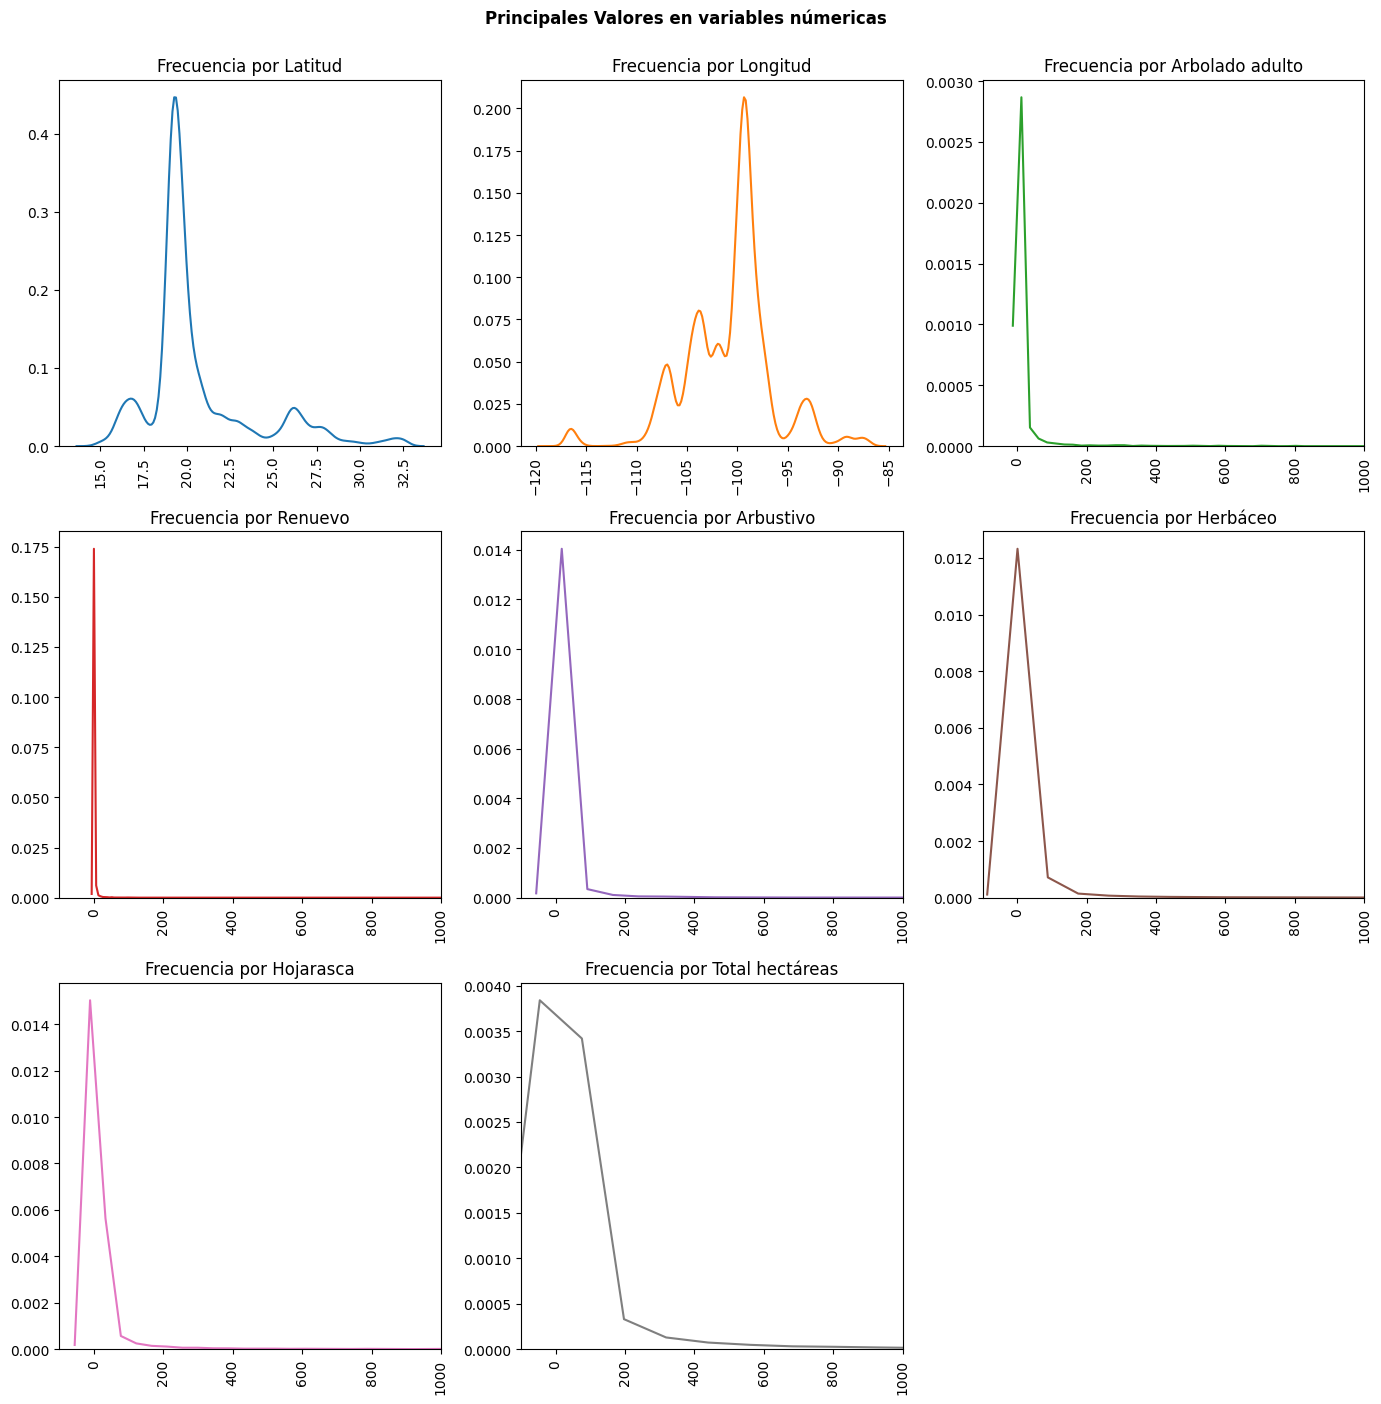

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(14,14))
plt.subplots_adjust(hspace=1)
ax = ax.flat
# Palette
colors = sns.color_palette(palette = 'tab10', n_colors = len(df.columns)+2)
for i, column in enumerate(numerical_variables.columns):
    sns.kdeplot(df[column], ax=ax[i], color=colors[i])
    ax[i].tick_params(axis='x', rotation=90)
    ax[i].set_title(f"Frecuencia por {column.capitalize()}")
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    if i > 1:
        ax[i].set_xlim([-100, 1000])



plt.suptitle("Principales Valores en variables númericas", y=1, fontweight="bold")
fig.delaxes(ax[8])
plt.tight_layout()
plt.show()

Como podemos observar la gran mayoria de valores númericos se concentran en rangos muy pequeños.

### Variables temporales

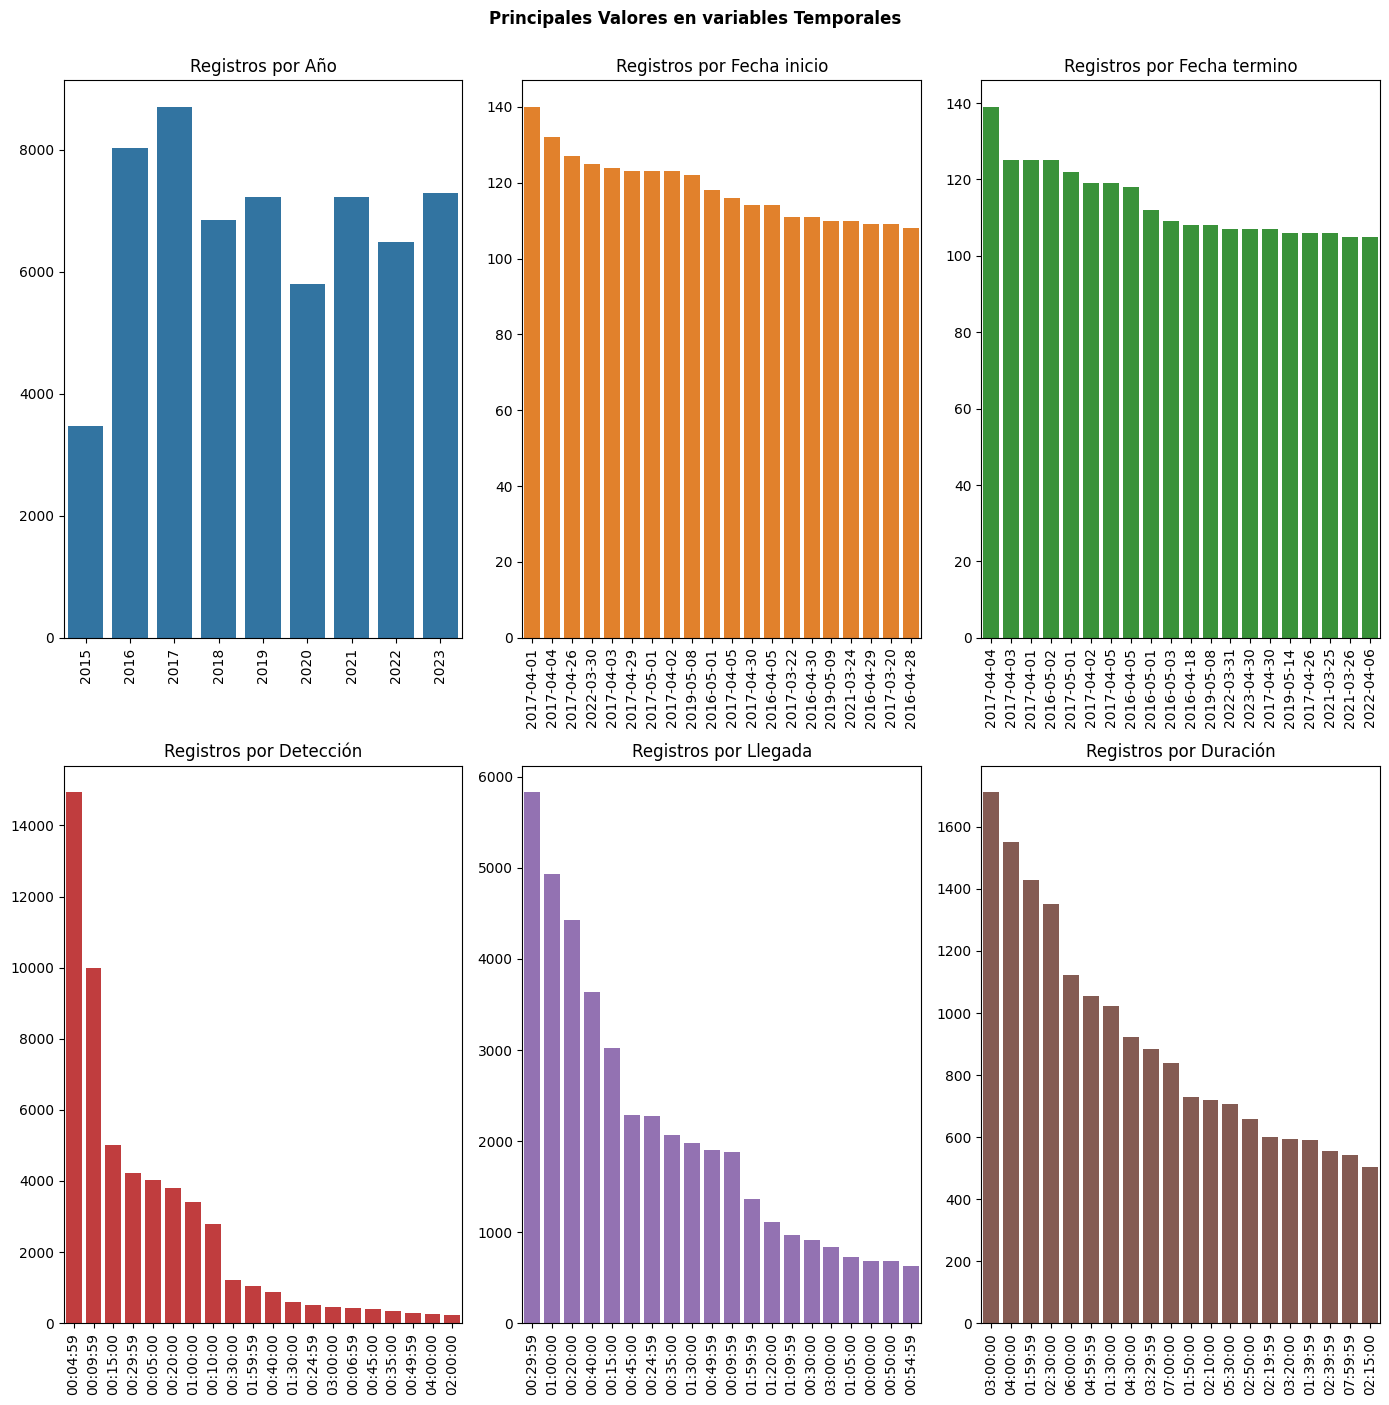

In [38]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(14,14))
plt.subplots_adjust(hspace=1)
ax = ax.flat
# Palette
colors = sns.color_palette(palette = 'tab10', n_colors = len(df.columns)+2)
for i, column in enumerate(times_variables.columns):
        sns.barplot(df[column].value_counts().head(20), ax=ax[i], color=colors[i])
        ax[i].set_title(f"Registros por {column.capitalize()}")
        ax[i].tick_params(axis='x', rotation=90)
        ax[i].set_xlabel("")
        ax[i].set_ylabel("")

plt.suptitle("Principales Valores en variables Temporales", y=1, fontweight="bold")
plt.tight_layout()
plt.show()

Las gráficas anteriores muestran que el año que más registros contiene fue el 2017, durante el mes Abril, las horas de mayor afluencia de incendios es cercana a la Media Noche y por lo general una gran parte de los incendios rondan entre 2 y 4 horas de duración, además de que el tiempo mayor de respuestas para arribar al lugar de los incendios va desde 20 min a 1 hora.

## Análisis Bivariable

### Mapa de Calor Variables Númericas

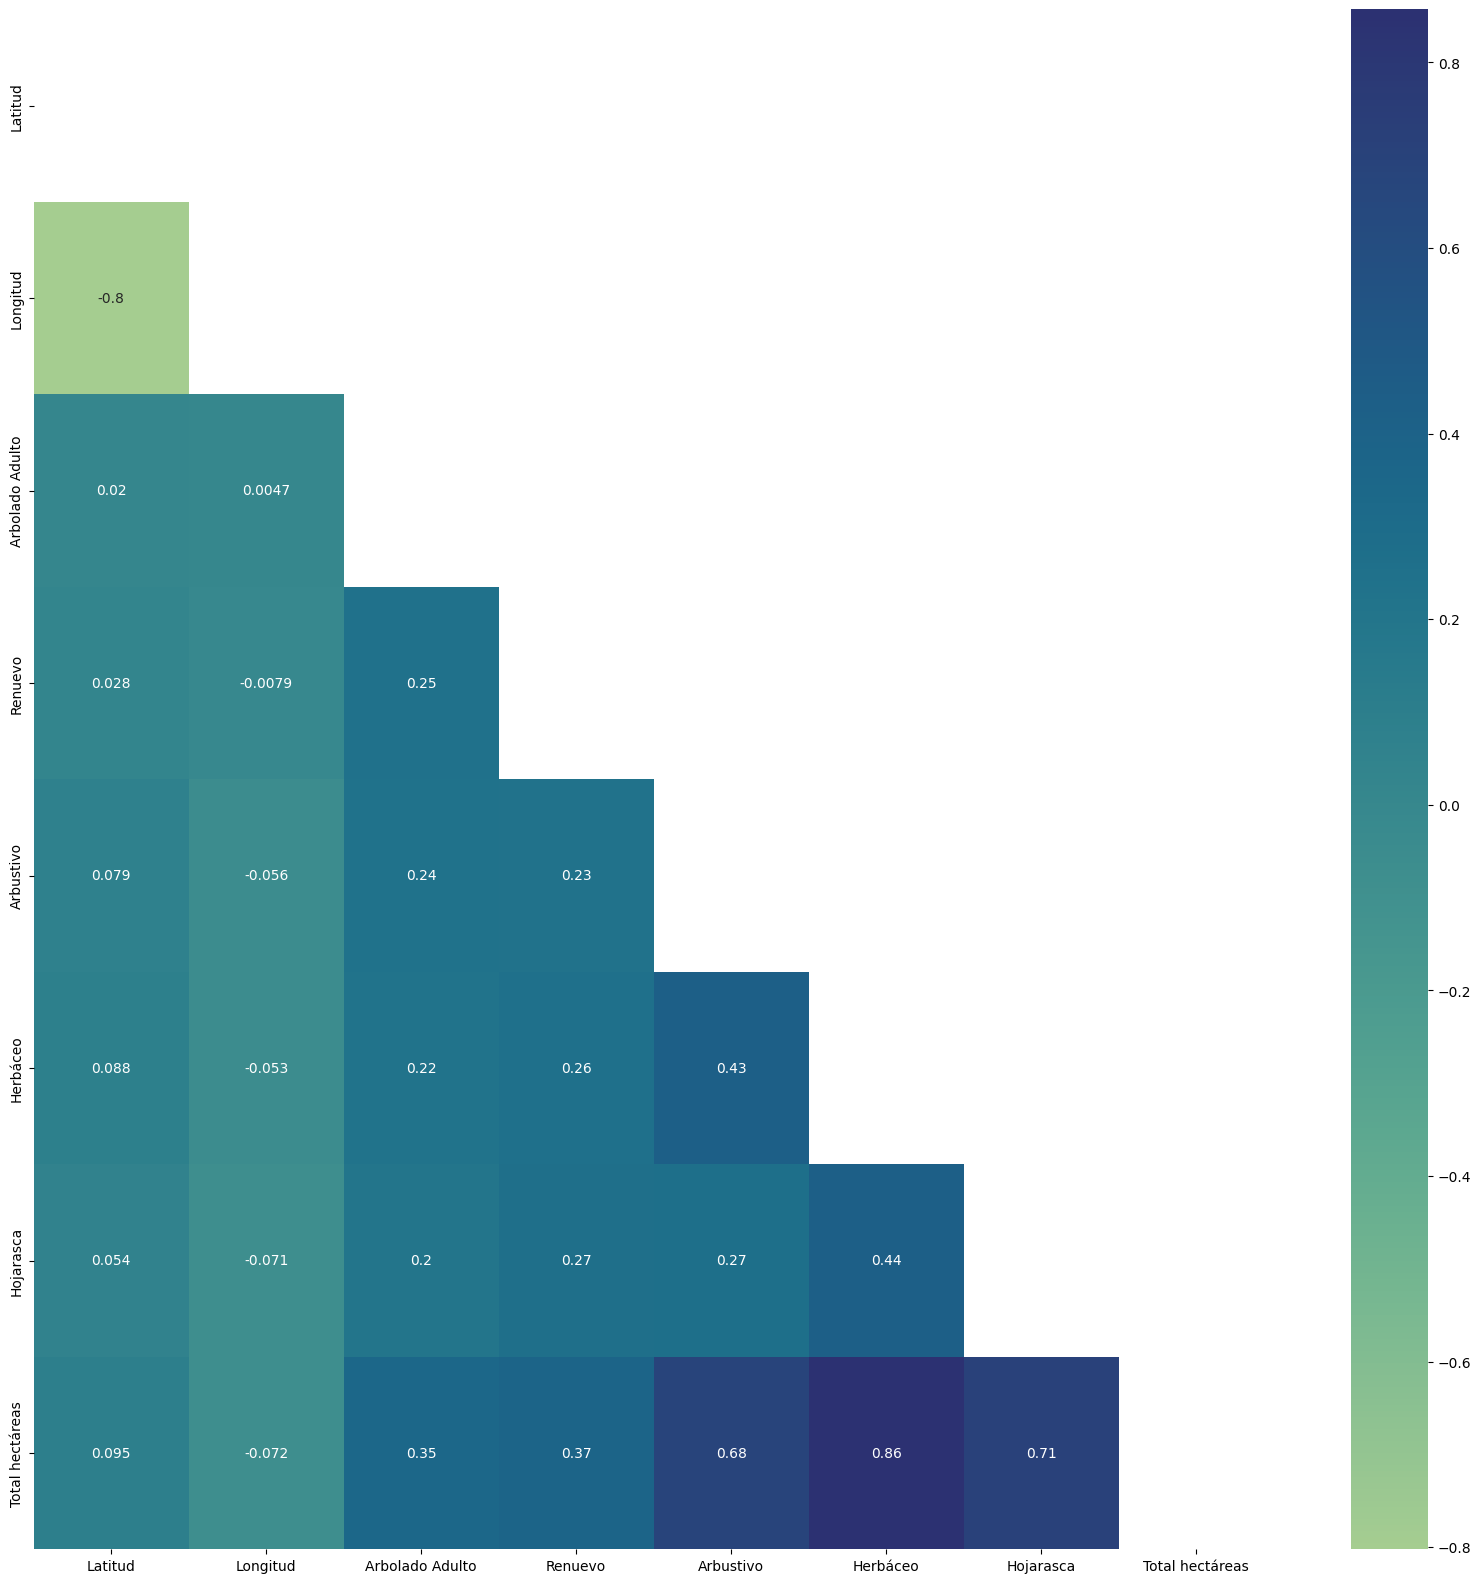

In [39]:
plt.figure(figsize=(20,20))
mask = np.triu(np.ones_like(numerical_variables.corr(), dtype=bool))
sns.heatmap(data=numerical_variables.corr(),annot=True, cmap="crest", mask=mask)
plt.show()

Este mapa de calor nos muestra que las variables con mayor correlación con el tipo de plantación Herbácea con el número total de hectáreas consumidas por incendios. De igual manera podemos observar que la mayoría del resto de variables no cuentan con alguna correlación relevante.

### Variables Categoricas

#### Principales Estados

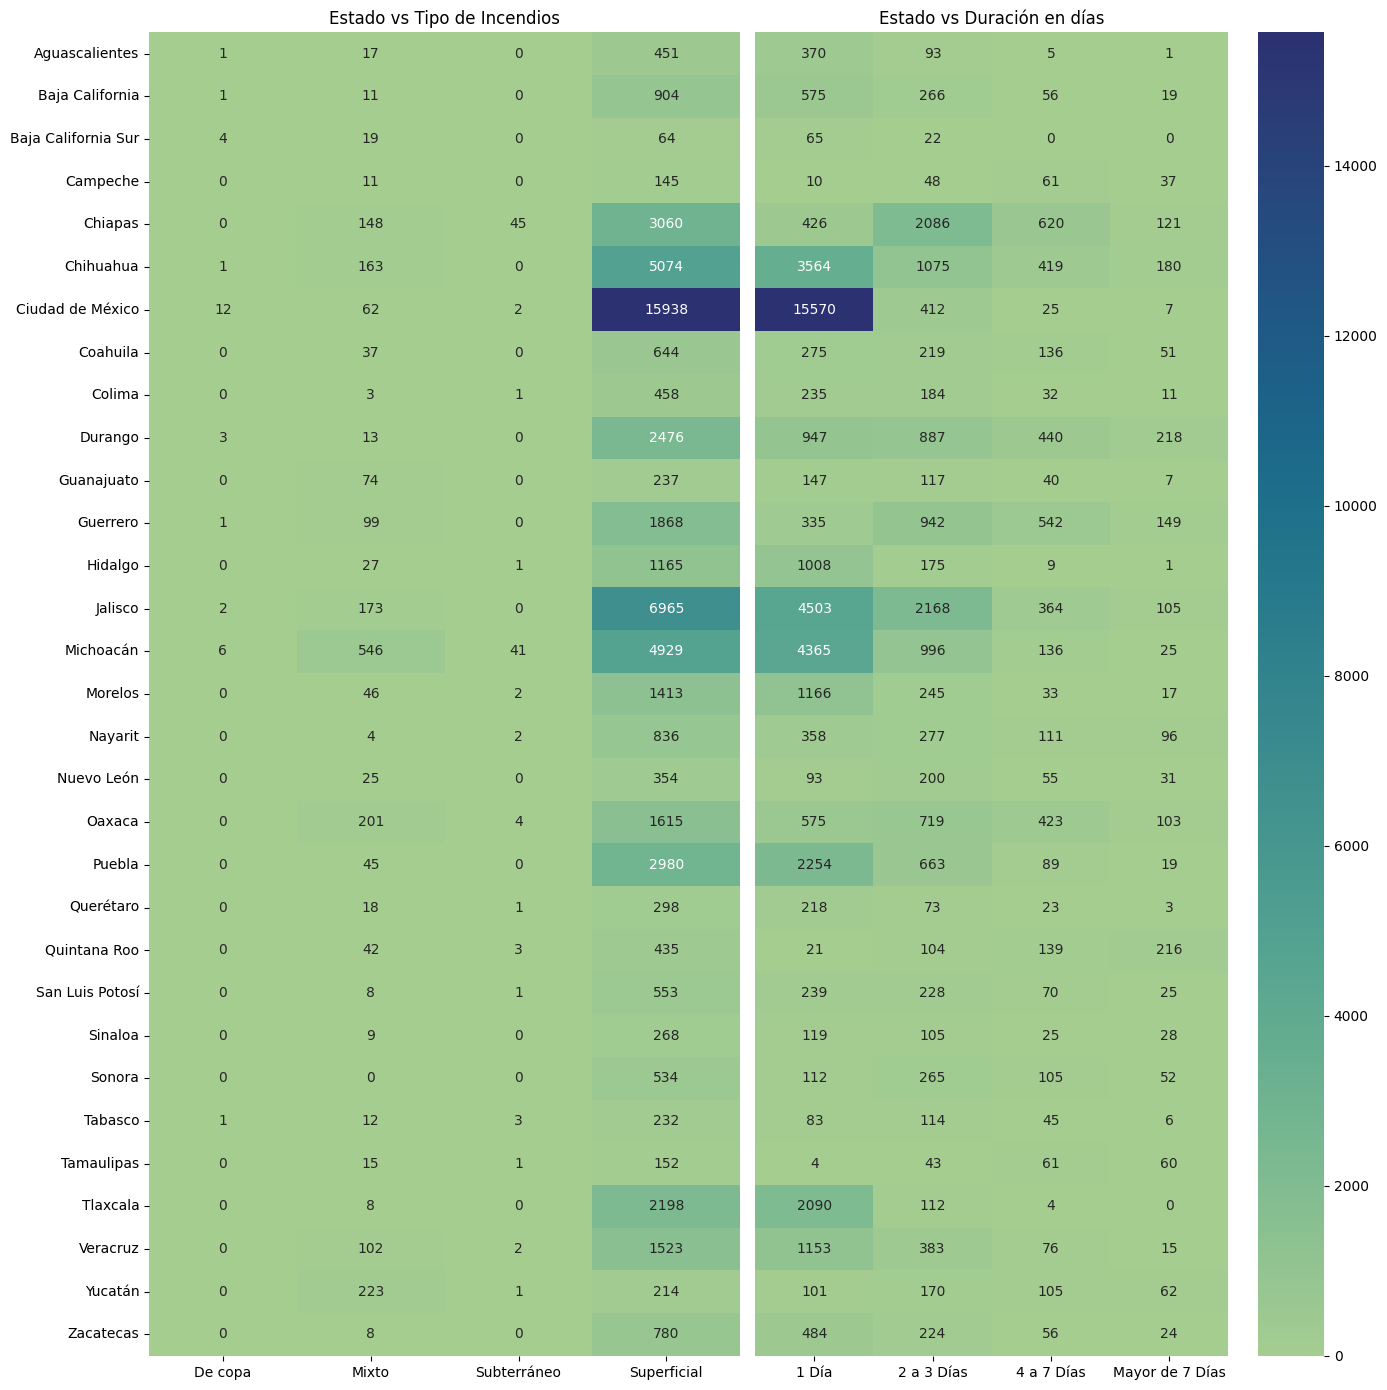

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,14))
ax = ax.flat
tabla_contingencia = pd.crosstab(index=df['Estado'], columns=df["Tipo de incendio"])
# Crear el mapa de calor usando Seaborn
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f",cbar=False, ax=ax[0])
ax[0].set_title('Estado vs Tipo de Incendios')
ax[0].set_xlabel("")
ax[0].set_ylabel("")

tabla_contingencia = pd.crosstab(index=df['Estado'], columns=df["Duración días"])
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f", ax=ax[1])
ax[1].set_title('Estado vs Duración en días')
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

Podemos observar que el estado con mayor cantidad incendios Superficiales es la Ciudad de México, Seguido por Jalisco y Chihuahua, además de que la duración promedio de los incendios es de entre 1 y 3 Días.

#### Causas relacionadas

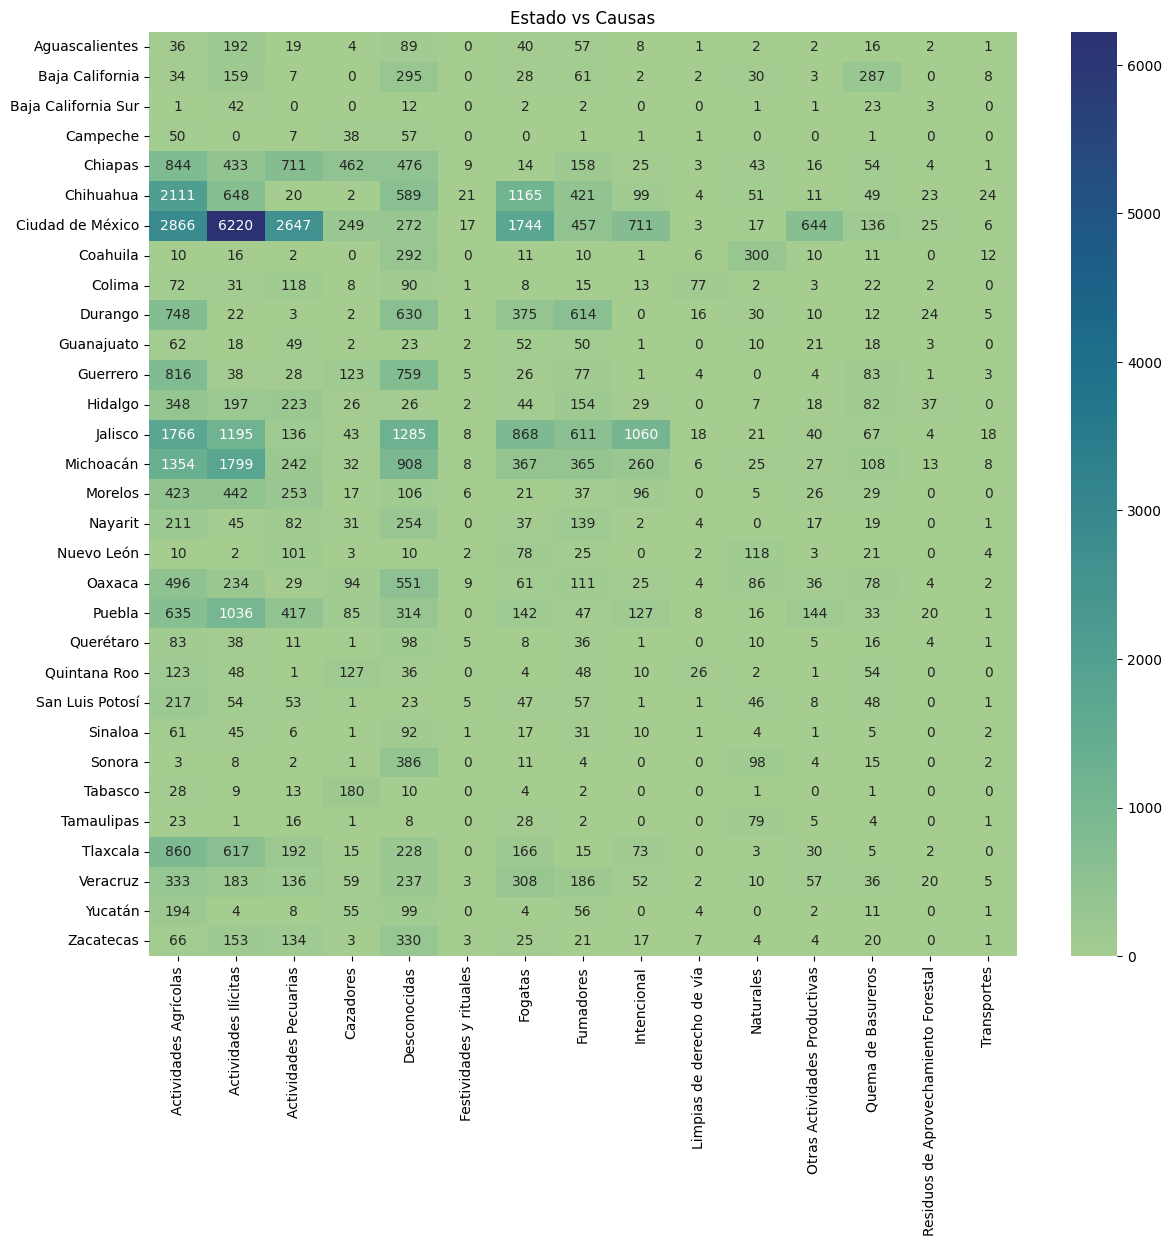

In [41]:
tabla_contingencia = pd.crosstab(index=df['Estado'], columns=df["Causa"])
# Crear el mapa de calor usando Seaborn
plt.figure(figsize=(14, 12))
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f")
plt.title('Estado vs Causas')
plt.xlabel("")
plt.ylabel("")
plt.show()

Algunas de las principales causas son las Actividades Agrícolas, Actividades Ilícitas y Pecuarias.

#### Tipos de Incendios

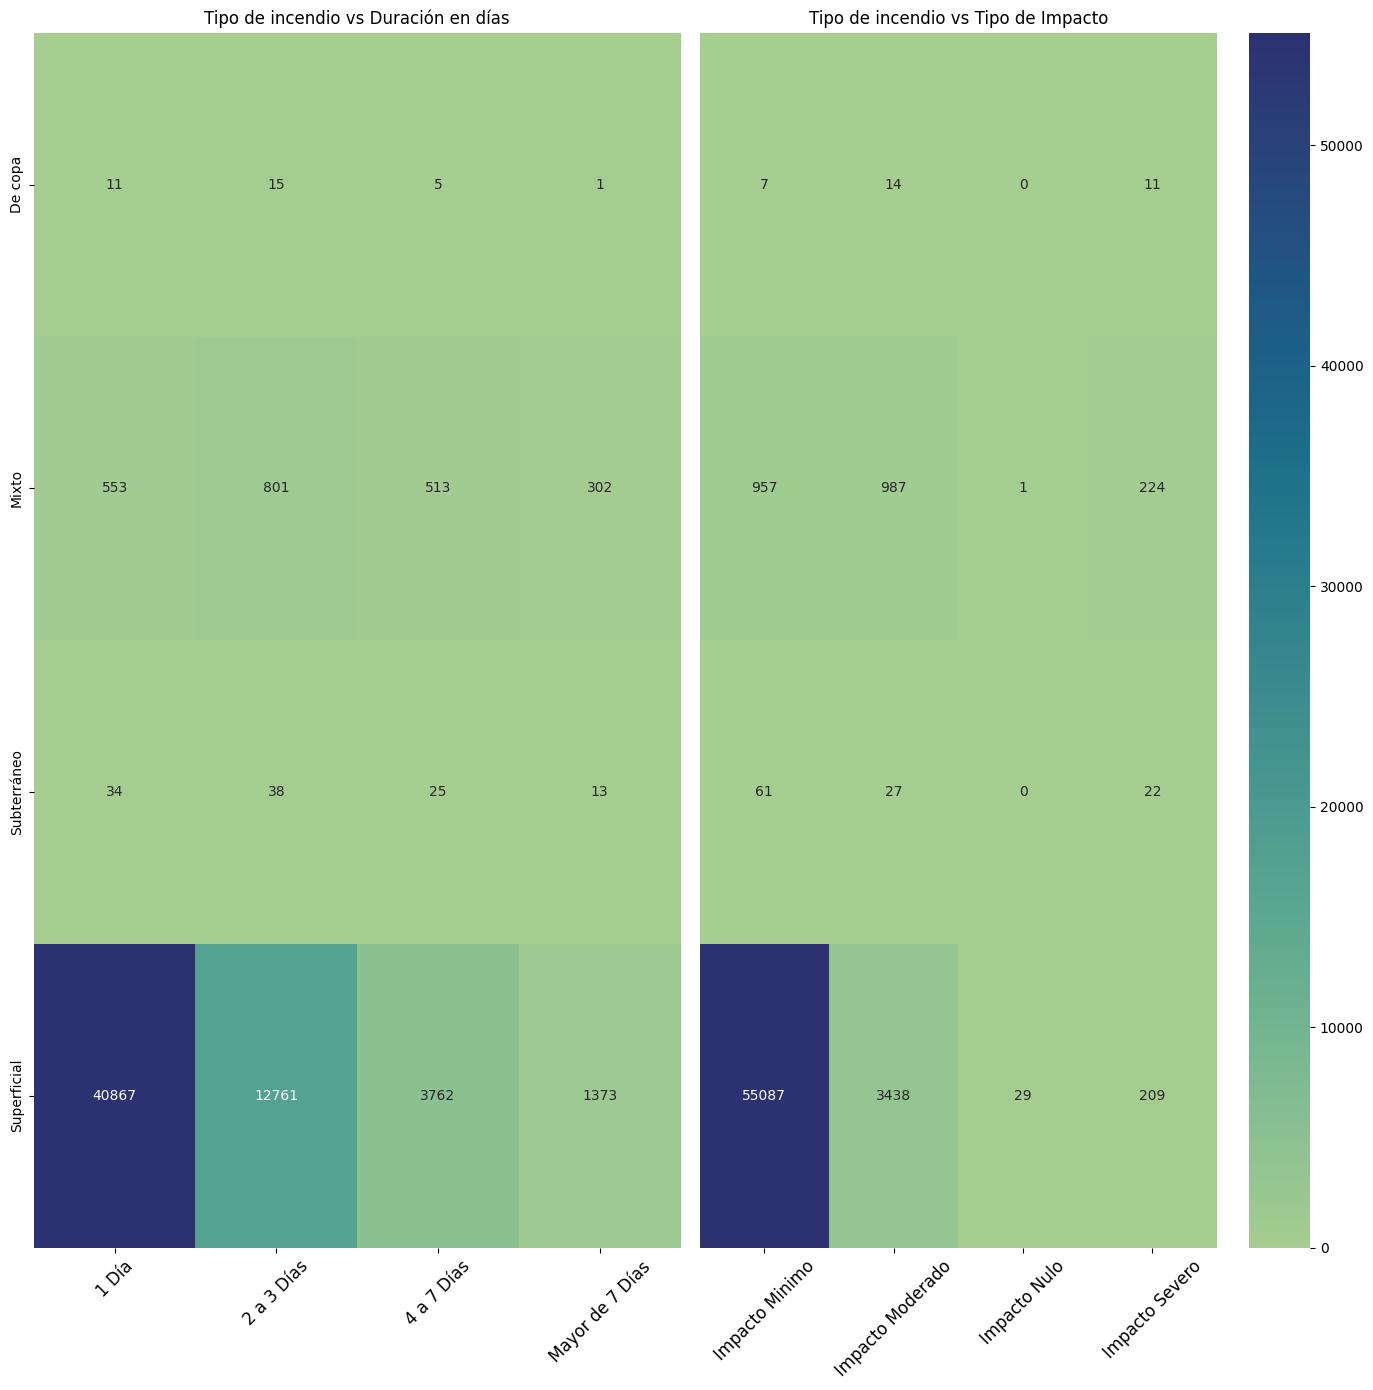

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,14))
ax = ax.flat
tabla_contingencia = pd.crosstab(index=df['Tipo de incendio'], columns=df["Duración días"])
# Crear el mapa de calor usando Seaborn
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f", cbar=False, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=12)
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_title('Tipo de incendio vs Duración en días')
ax[0].set_xlabel("")
ax[0].set_ylabel("")

tabla_contingencia = pd.crosstab(index=df['Tipo de incendio'], columns=df["Tipo impacto"])
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f", ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=12)
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Tipo de incendio vs Tipo de Impacto')
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_yticks([])

plt.tight_layout()
plt.show()

#### Tamaño de incendios

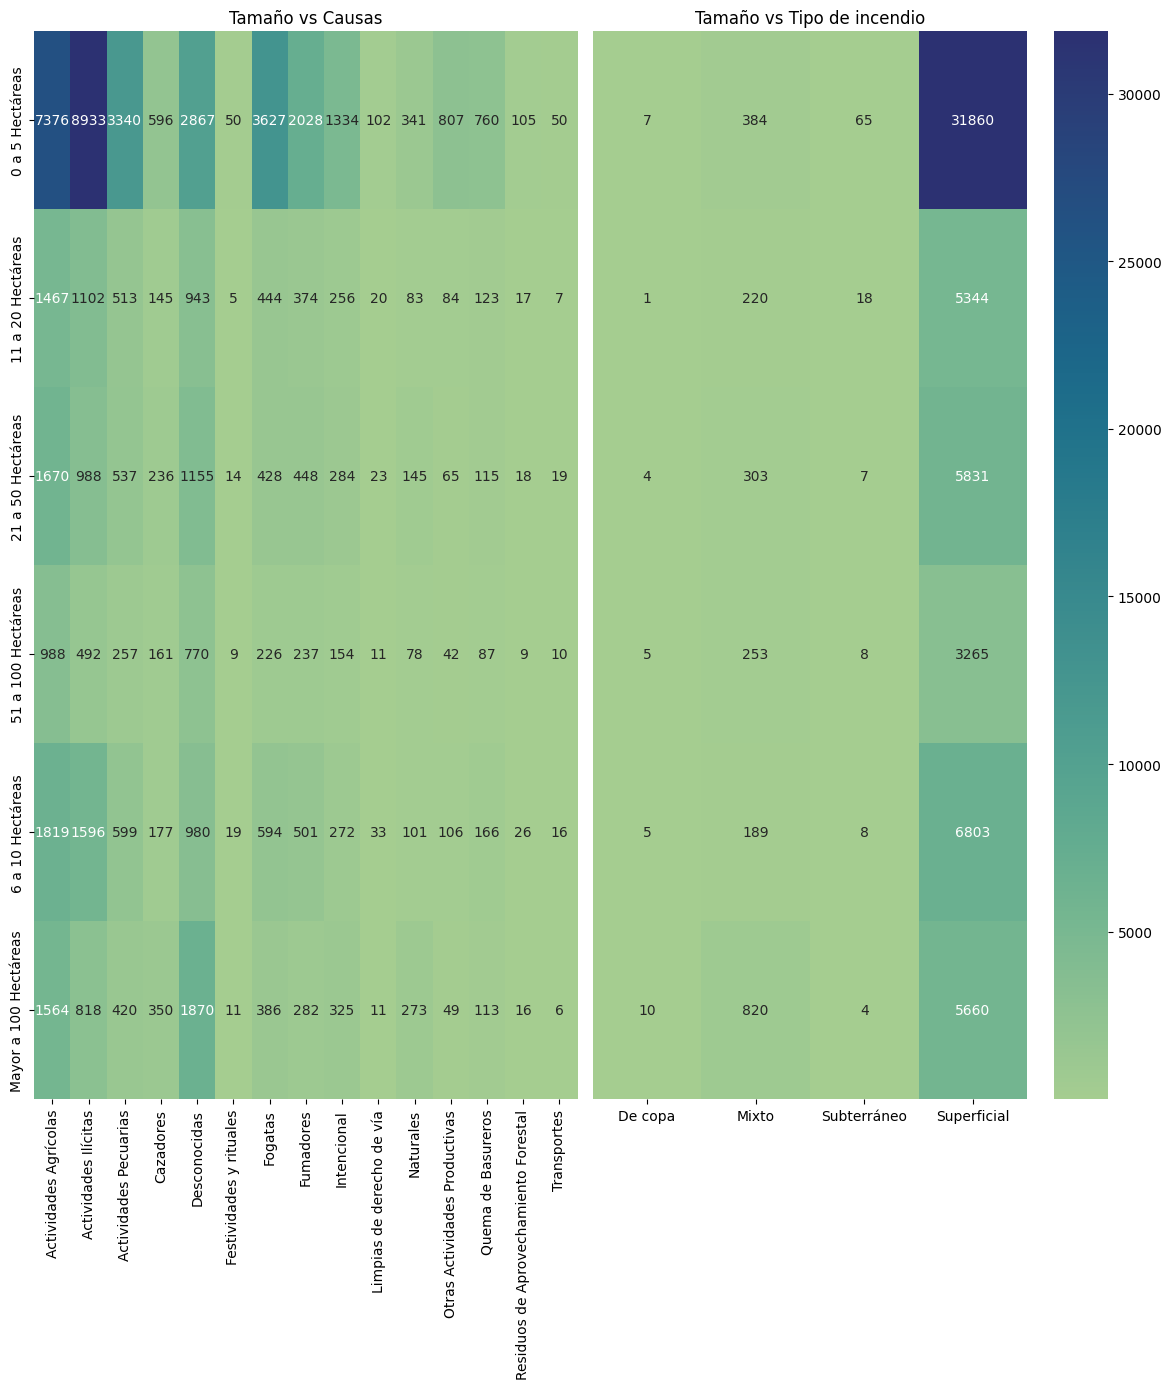

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,14))
ax = ax.flat
tabla_contingencia = pd.crosstab(index=df['Tamaño'], columns=df["Causa"])
# Crear el mapa de calor usando Seaborn
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f", cbar=False, ax=ax[0])
ax[0].set_title('Tamaño vs Causas')
ax[0].set_xlabel("")
ax[0].set_ylabel("")

tabla_contingencia = pd.crosstab(index=df['Tamaño'], columns=df["Tipo de incendio"])
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f",  ax=ax[1])
ax[1].set_title('Tamaño vs Tipo de incendio')
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_yticks([])
    
plt.tight_layout()
plt.show()

#### Regimen de fuegos

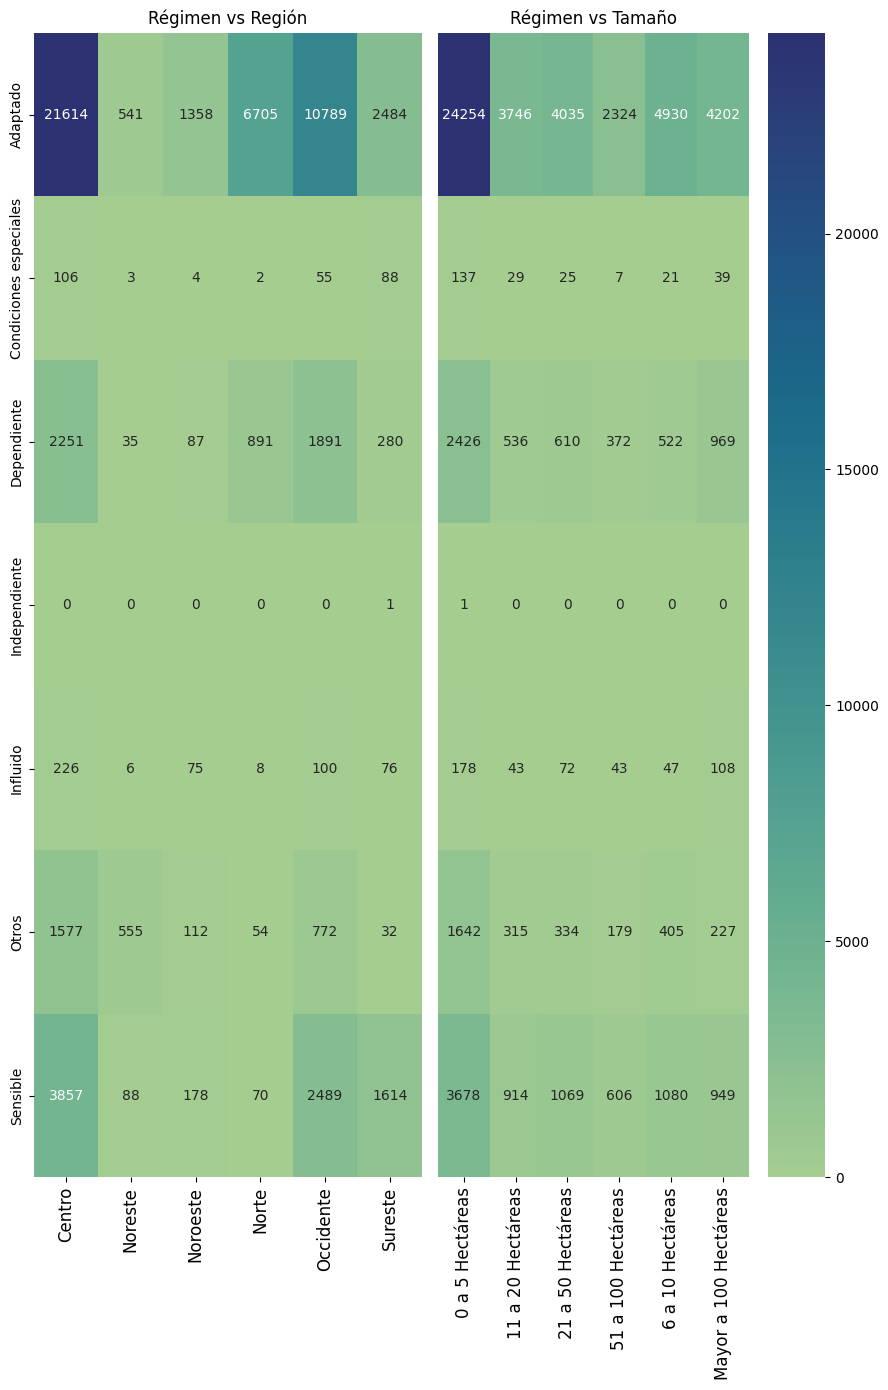

In [44]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,14))
ax = ax.flat
tabla_contingencia = pd.crosstab(index=df['Régimen de fuego'], columns=df["Región"])
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f", cbar=False, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=12)
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title('Régimen vs Región')
ax[0].set_xlabel("")
ax[0].set_ylabel("")

tabla_contingencia = pd.crosstab(index=df['Régimen de fuego'], columns=df["Tamaño"])
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f",  ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=12)
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title('Régimen vs Tamaño')
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_yticks([])
    
plt.tight_layout()
plt.show()

#### Tipo de Vegetación

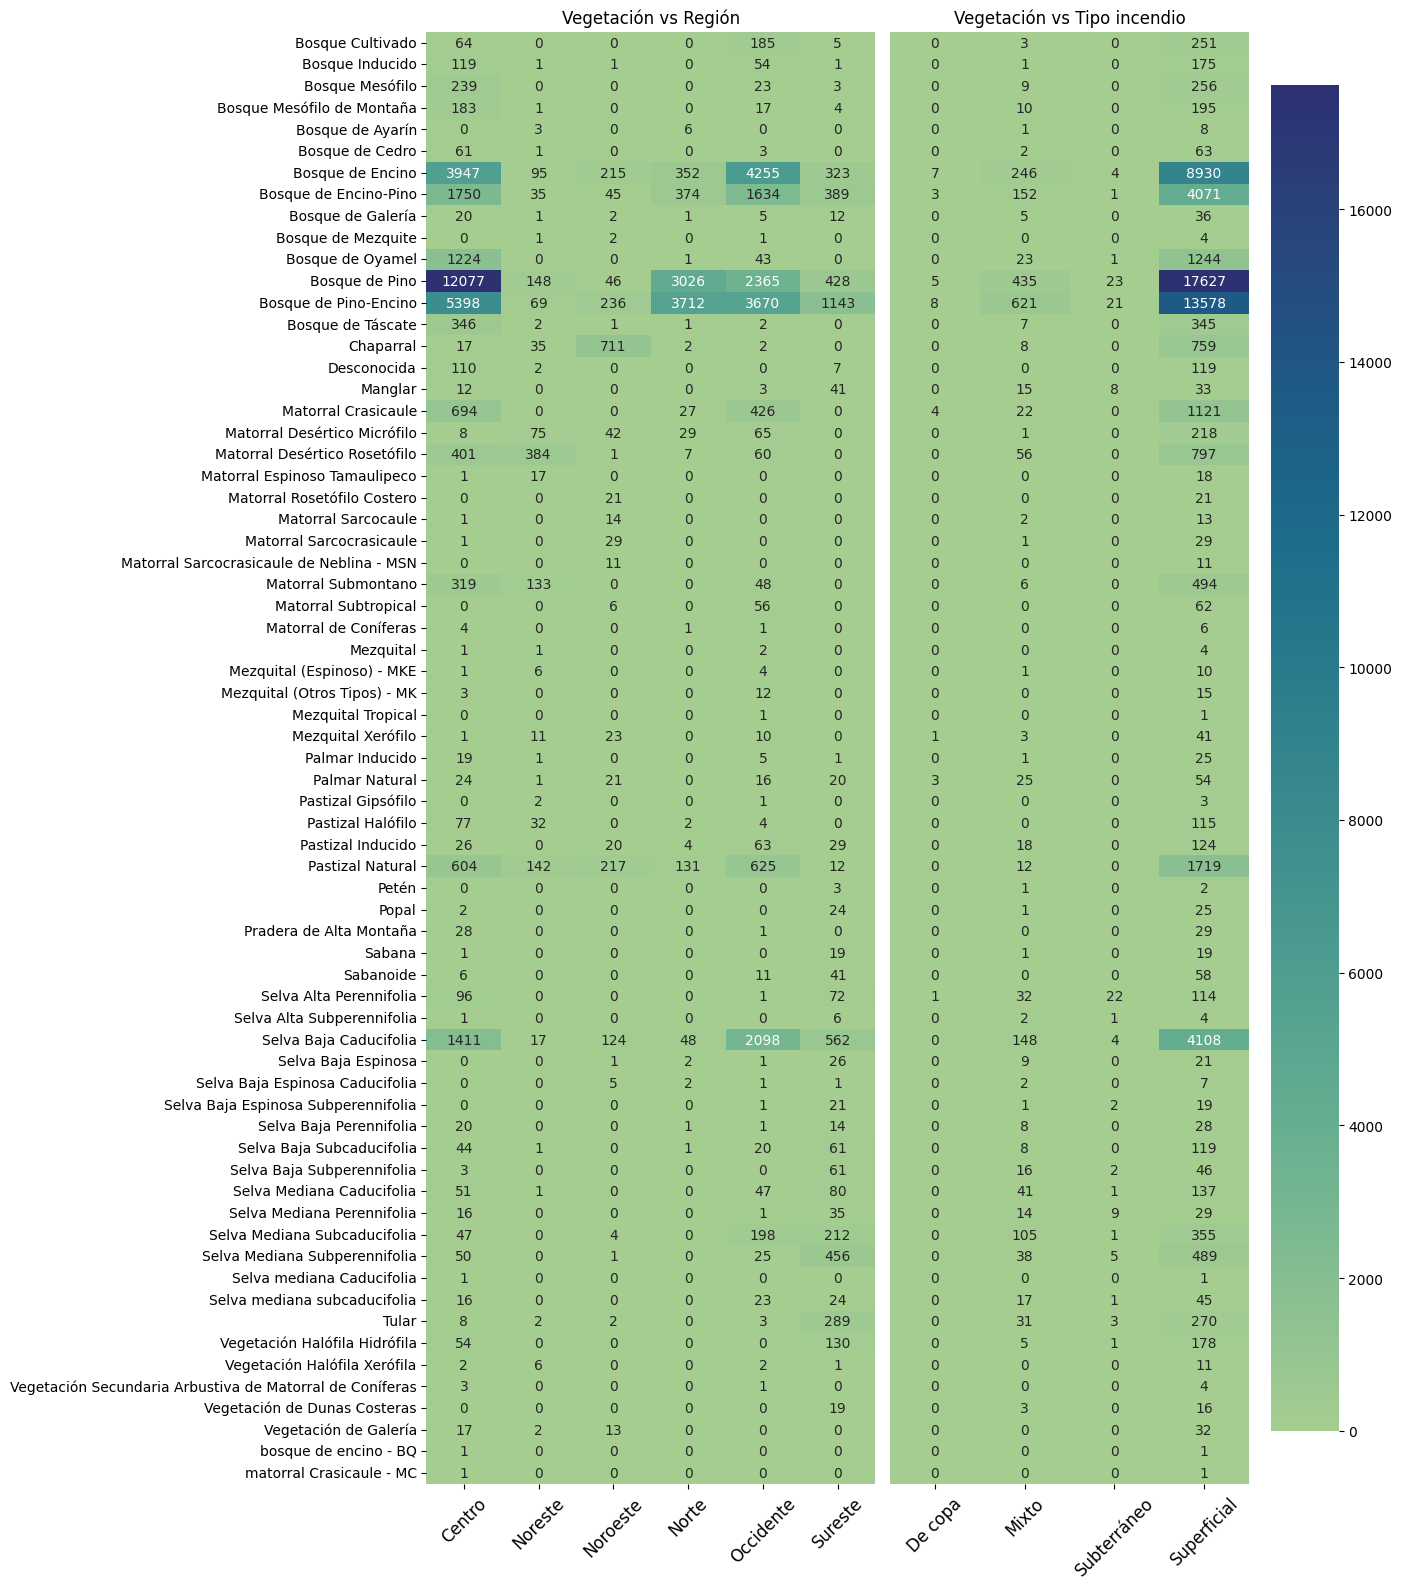

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,16))
ax = ax.flat
tabla_contingencia = pd.crosstab(index=df['Tipo Vegetación'], columns=df["Región"])
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f", cbar=False, ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=12)
ax[0].set_title('Vegetación vs Región')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_xlabel("")
ax[0].set_ylabel("")

tabla_contingencia = pd.crosstab(index=df['Tipo Vegetación'], columns=df["Tipo de incendio"])
sns.heatmap(tabla_contingencia, annot=True, cmap="crest", fmt=".0f",  ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize=12)
ax[1].set_title('Vegetación vs Tipo incendio')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[1].set_yticks([])
    
plt.tight_layout()
plt.show()

## Variables Temporales

In [46]:
times_variables.head()

,Año,Fecha Inicio,Fecha Termino,Detección,Llegada,Duración
0,2015,2015-01-01,2015-01-02,00:09:59,00:35:00,07:00:00
1,2015,2015-01-01,2015-01-01,00:08:00,00:40:00,02:50:00
2,2015,2015-01-01,2015-01-01,00:04:59,00:15:00,24:20:00
3,2015,2015-01-01,2015-01-01,00:06:00,00:24:59,01:41:00
4,2015,2015-01-01,2015-01-01,00:20:00,00:35:00,25:59:59


In [47]:
# Conversión de variables para mejor procedimiento en mapas de calor
times_variables["Fecha Inicio"] = pd.to_datetime(times_variables["Fecha Inicio"])
times_variables["Fecha Termino"] = pd.to_datetime(times_variables["Fecha Termino"])
times_variables["Detección"] = pd.to_datetime(times_variables["Detección"], format='%H:%M:%S').dt.time
times_variables["Llegada"] = pd.to_datetime(times_variables["Llegada"], format='%H:%M:%S').dt.time
times_variables["Duración"] = pd.to_timedelta(times_variables["Duración"])

### Recurrencia de Incendios por Hora y Fecha

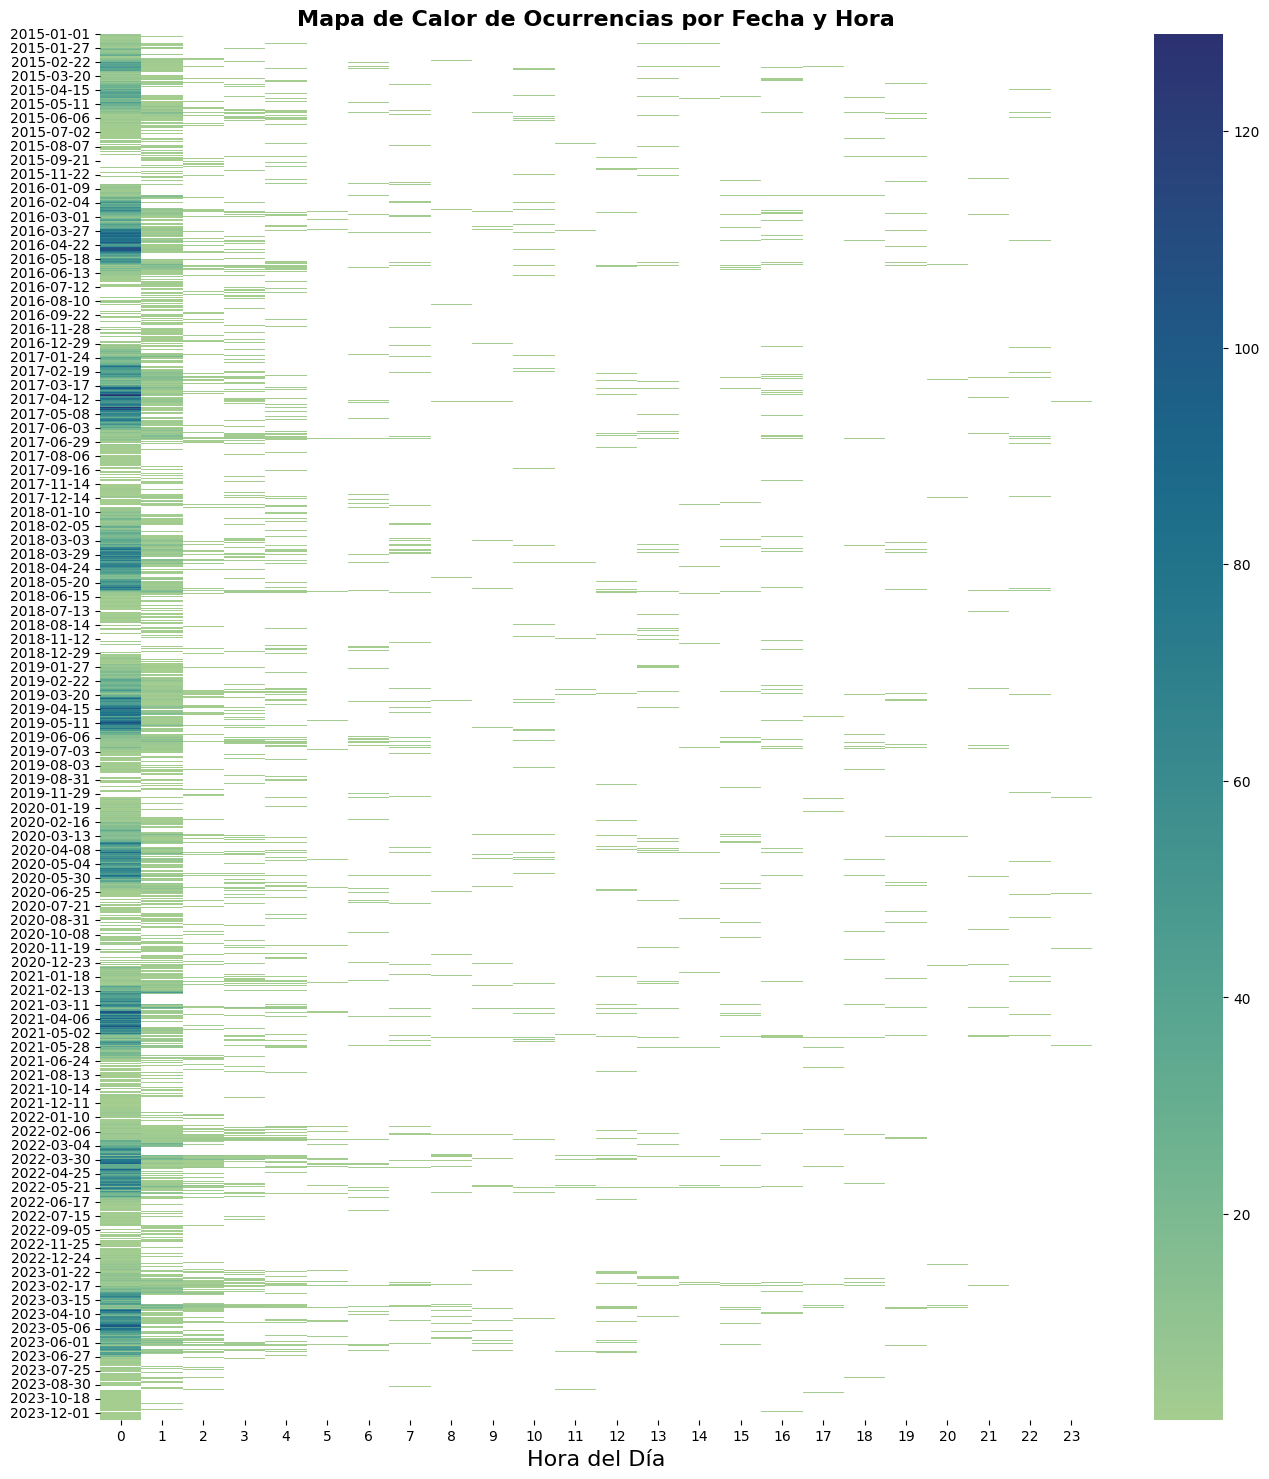

In [48]:
# Preprocesamiento de variables de tiempo
times_variables['Hour'] = times_variables['Detección'].apply(lambda x: x.hour)
heatmap_data = times_variables.groupby(['Fecha Inicio', 'Hour']).size().reset_index(name='Counts')
heatmap_data["Fecha Inicio"] = heatmap_data["Fecha Inicio"].dt.date
heatmap_data_pivot = heatmap_data.pivot(index='Fecha Inicio',columns= 'Hour',values= 'Counts')
# Gráfico de Calor 
plt.figure(figsize=(16, 18))
sns.heatmap(heatmap_data_pivot, cmap='crest')
plt.title('Mapa de Calor de Ocurrencias por Fecha y Hora', fontsize=16, fontweight="bold")
plt.xlabel('Hora del Día', fontsize=16)
plt.ylabel('')
plt.show()

### Recurrencia de Incendios por Fechas de Termino y Duración

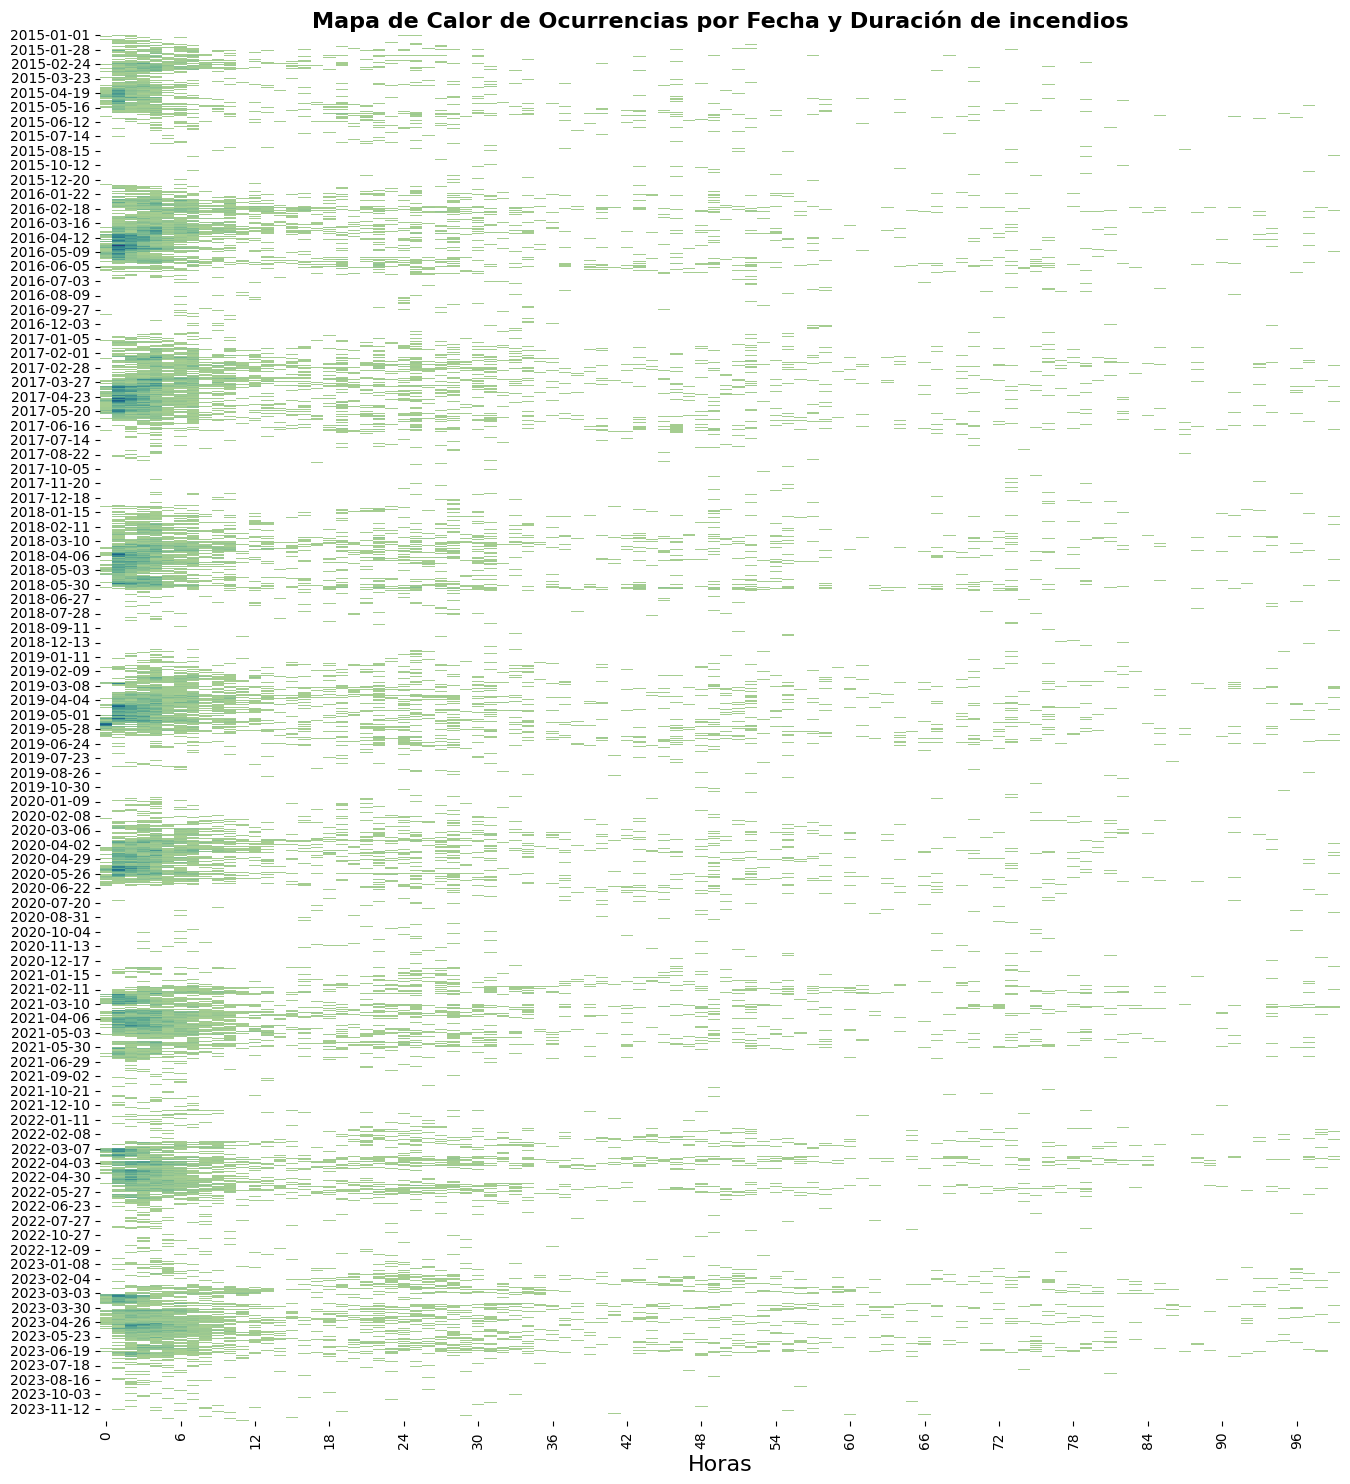

In [49]:
# Preprocesamiento de variables de tiempo
times_variables['Hour'] = times_variables['Duración'].apply(lambda x: x.total_seconds()//3600)
times_variables["Hour"] = times_variables["Hour"].astype(int)
heatmap_data = times_variables.groupby(['Fecha Termino', 'Hour']).size().reset_index(name='Counts')
heatmap_data["Fecha Termino"] = heatmap_data["Fecha Termino"].dt.date
heatmap_data_pivot = heatmap_data.pivot(index='Fecha Termino',columns= 'Hour',values= 'Counts')
# Gráfico de Calor 
plt.figure(figsize=(16, 18))
sns.heatmap(heatmap_data_pivot, cmap='crest', annot=False, cbar=False)
plt.title('Mapa de Calor de Ocurrencias por Fecha y Duración de incendios', fontsize=16, fontweight="bold")
plt.xlabel('Horas', fontsize=16)
plt.xlim(0,100)
plt.ylabel('')
plt.show()

## Preprocesamiento